In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from datetime import datetime
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_score, recall_score,
                            f1_score, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_logs = pd.read_csv('access-1year-sorted.csv')
df_logs.head()

,ip,timestamp,request,status,size,referer,user_agent
0,185.244.104.2,2025-10-01 00:01:29+07:00,PROPFIND / HTTP/1.1,301,162,http://207.148.71.21:443/,-
1,165.227.100.212,2025-10-01 00:02:23+07:00,GET /robots.txt HTTP/1.0,400,248,-,xfa1
2,167.172.180.168,2025-10-01 00:03:57+07:00,GET /favicon.ico HTTP/1.1,404,146,http://207.148.71.21/,Mozilla/5.0 (X11; Linux x86_64; rv:137.0) Geck...
3,167.172.180.168,2025-10-01 00:03:57+07:00,GET / HTTP/1.1,404,146,-,Mozilla/5.0 (X11; Linux x86_64; rv:137.0) Geck...
4,79.124.58.198,2025-10-01 00:24:06+07:00,GET /?XDEBUG_SESSION_START=phpstorm HTTP/1.1,404,178,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


In [3]:
# Data Cleaning

# 1. Remove rows with missing crucial data (e.g., missing 'ip' or 'timestamp')
df_logs_clean = df_logs.dropna(subset=['ip', 'timestamp'])

# 2. Remove duplicated entries (full duplicates)
df_logs_clean = df_logs_clean.drop_duplicates()

# 3. Optionally, remove rows with impossible status codes or negative size
# (Status codes are 100-599; sizes should not be negative.)
df_logs_clean = df_logs_clean[
    (df_logs_clean['status'].between(100, 599, inclusive='both')) &
    (df_logs_clean['size'] >= 0)
]

# 4. Convert 'status' and 'size' to integer if not already
df_logs_clean['status'] = df_logs_clean['status'].astype(int)
df_logs_clean['size'] = df_logs_clean['size'].astype(int)

# 5. Remove leading/trailing whitespaces in string columns
for col in ['ip', 'request', 'referer', 'user_agent']:
    df_logs_clean[col] = df_logs_clean[col].astype(str).str.strip()

# Show sample after cleaning
print(f"Data setelah cleaning: {len(df_logs_clean):,} baris")
display(df_logs_clean.head())



Data setelah cleaning: 55,390 baris


,ip,timestamp,request,status,size,referer,user_agent
0,185.244.104.2,2025-10-01 00:01:29+07:00,PROPFIND / HTTP/1.1,301,162,http://207.148.71.21:443/,-
1,165.227.100.212,2025-10-01 00:02:23+07:00,GET /robots.txt HTTP/1.0,400,248,-,xfa1
2,167.172.180.168,2025-10-01 00:03:57+07:00,GET /favicon.ico HTTP/1.1,404,146,http://207.148.71.21/,Mozilla/5.0 (X11; Linux x86_64; rv:137.0) Geck...
3,167.172.180.168,2025-10-01 00:03:57+07:00,GET / HTTP/1.1,404,146,-,Mozilla/5.0 (X11; Linux x86_64; rv:137.0) Geck...
4,79.124.58.198,2025-10-01 00:24:06+07:00,GET /?XDEBUG_SESSION_START=phpstorm HTTP/1.1,404,178,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


In [4]:


# 1. Frekuensi kemunculan IP
df_logs_clean['ip_freq'] = df_logs_clean['ip'].map(df_logs_clean['ip'].value_counts())

# 2. Metode HTTP request (GET, POST, dst)
df_logs_clean['method'] = df_logs_clean['request'].str.extract(r'^([A-Z]+)')

# 3. Panjang path/URL pada request
df_logs_clean['path_length'] = df_logs_clean['request'].str.extract(r'^[A-Z]+\s+([^\s]+)').fillna('').apply(lambda x: x.str.len())

# 4. One-hot encoding status code (optional, bisa digunakan untuk model berbasis feature vector)
status_dummies = pd.get_dummies(df_logs_clean['status'], prefix='status')
df_logs_clean = pd.concat([df_logs_clean, status_dummies], axis=1)

# 5. Deteksi user-agent mengandung keyword bot/otomasi/tools/crawler/scan
user_agent_lower = df_logs_clean['user_agent'].str.lower()
df_logs_clean['is_bot_ua'] = user_agent_lower.str.contains('bot|crawler|spider|scrapy|curl|python|scan|zgrab|winhttp', regex=True).astype(int)

# 6. Kolom apakah referer tersedia (1 = ada, 0 = "-")
df_logs_clean['has_referer'] = (df_logs_clean['referer'] != "-").astype(int)

# 7. Jumlah request unik per IP (untuk mendeteksi variasi perilaku per-IP)
df_logs_clean['uniq_req_by_ip'] = df_logs_clean.groupby('ip')['request'].transform('nunique')

# 8. Jam pada timestamp (secara numerik, fitur waktu)
df_logs_clean['hour'] = pd.to_datetime(df_logs_clean['timestamp']).dt.hour

# 9. Ekstrak URI dari request untuk analisis keamanan
df_logs_clean['uri'] = df_logs_clean['request'].str.extract(r'^[A-Z]+\s+([^\s]+)').fillna('')

# 10. Deteksi SQL Injection patterns
sql_patterns = r"(union\s+select|select\s+.*\s+from|insert\s+into|delete\s+from|drop\s+table|exec\s*\(|'(\s*or\s*|\s*and\s*)'|'(\s*or\s*|\s*and\s*)\d+='|\d+\s*=\s*\d+)"
df_logs_clean['has_sql_injection'] = df_logs_clean['uri'].str.lower().str.contains(sql_patterns, regex=True, na=False).astype(int)

# 11. Deteksi XSS (Cross-Site Scripting) patterns
xss_patterns = r"(<script|javascript:|onerror=|onload=|onclick=|eval\(|alert\(|document\.cookie|\.innerHTML)"
df_logs_clean['has_xss'] = df_logs_clean['uri'].str.lower().str.contains(xss_patterns, regex=True, na=False).astype(int)

# 12. Deteksi Path Traversal attempts
path_traversal_patterns = r"(\.\./|\.\.\\|\.\.%2f|\.\.%5c|%2e%2e%2f|%2e%2e%5c)"
df_logs_clean['has_path_traversal'] = df_logs_clean['uri'].str.lower().str.contains(path_traversal_patterns, regex=True, na=False).astype(int)

# 13. Deteksi Command Injection patterns
cmd_injection_patterns = r"(\||;|\$\(|`|&&|\|\||\s+cat\s+|\s+ls\s+|\s+rm\s+|\s+wget\s+|\s+curl\s+)"
df_logs_clean['has_command_injection'] = df_logs_clean['uri'].str.lower().str.contains(cmd_injection_patterns, regex=True, na=False).astype(int)

# 14. Deteksi URL encoding patterns (suspicious encoding)
df_logs_clean['has_encoded_chars'] = df_logs_clean['uri'].str.contains(r'%[0-9a-fA-F]{2}', regex=True, na=False).astype(int)

# 15. Jumlah query parameters dalam URL
def count_query_params(uri):
    """Count number of query parameters in URI"""
    if '?' not in str(uri):
        return 0
    query_part = str(uri).split('?')[1].split('#')[0]  # Get query part, remove fragment
    if not query_part:
        return 0
    return query_part.count('&') + 1  # Number of '&' + 1 = number of params

df_logs_clean['num_query_params'] = df_logs_clean['uri'].apply(count_query_params)

# 16. Deteksi suspicious paths (admin, config, backup, etc.)
suspicious_paths = r"(admin|config|backup|test|debug|phpinfo|\.env|\.git|wp-admin|phpmyadmin|\.sql|\.bak)"
df_logs_clean['is_suspicious_path'] = df_logs_clean['uri'].str.lower().str.contains(suspicious_paths, regex=True, na=False).astype(int)

# 17. Entropy dari request URI (untuk mendeteksi encoded/obfuscated attacks)
def calculate_entropy(text):
    """Calculate Shannon entropy of a string"""
    if not text or len(text) == 0:
        return 0.0
    text = str(text).lower()
    prob = [float(text.count(c)) / len(text) for c in dict.fromkeys(list(text))]
    entropy = -sum([p * np.log2(p) for p in prob if p > 0])
    return entropy

df_logs_clean['request_entropy'] = df_logs_clean['uri'].apply(calculate_entropy)

# ------------------------------
# FEATURE SELECTION
# ------------------------------
# Pilih subset fitur utama yang paling relevan untuk deteksi anomali (17 fitur total)
selected_features = [
    'ip_freq',
    'method',
    'path_length',
    'status',
    'size',
    'is_bot_ua',
    'has_referer',
    'uniq_req_by_ip',
    'hour',
    'has_sql_injection',
    'has_xss',
    'has_path_traversal',
    'has_command_injection',
    'has_encoded_chars',
    'num_query_params',
    'is_suspicious_path',
    'request_entropy'
]

# Tampilkan contoh setelah feature engineering dan selection
print("Sample after feature engineering & feature selection:")
display(df_logs_clean[selected_features].head())




Sample after feature engineering & feature selection:


,ip_freq,method,path_length,status,size,is_bot_ua,has_referer,uniq_req_by_ip,hour,has_sql_injection,has_xss,has_path_traversal,has_command_injection,has_encoded_chars,num_query_params,is_suspicious_path,request_entropy
0,552,PROPFIND,1,301,162,0,1,2,0,0,0,0,0,0,0,0,-0.000000
1,16,GET,11,400,248,0,0,3,0,0,0,0,0,0,0,0,2.845351
2,2,GET,12,404,146,0,1,2,0,0,0,0,0,0,0,0,3.084963
3,2,GET,1,404,146,0,0,2,0,0,0,0,0,0,0,0,-0.000000
4,250,GET,31,404,178,0,0,51,0,0,0,0,0,0,1,1,4.103728


In [6]:
# Membuat label berdasarkan rule-based approach
# Label: 1 = Anomaly, 0 = Normal

# Kriteria untuk mendeteksi anomaly:
# 1. Deteksi serangan langsung (SQL injection, XSS, path traversal, command injection)
# 2. Status code error (4xx client error, 5xx server error)
# 3. Suspicious paths
# 4. High entropy (mungkin encoded/obfuscated attacks)
# 5. Kombinasi beberapa indikator mencurigakan

# Inisialisasi kolom label
df_logs_clean['label'] = 0  # Default: Normal

# Kriteria 1: Deteksi serangan langsung (sangat jelas anomaly)
has_attack = (
    (df_logs_clean['has_sql_injection'] == 1) |
    (df_logs_clean['has_xss'] == 1) |
    (df_logs_clean['has_path_traversal'] == 1) |
    (df_logs_clean['has_command_injection'] == 1)
)

# Kriteria 2: Status code error (4xx, 5xx) - bisa indikasi serangan atau error
is_error_status = df_logs_clean['status'].isin([400, 401, 403, 404, 500, 502, 503, 504])

# Kriteria 3: Suspicious paths dengan status error atau encoded chars
is_suspicious = (
    (df_logs_clean['is_suspicious_path'] == 1) & 
    (is_error_status | (df_logs_clean['has_encoded_chars'] == 1))
)

# Kriteria 4: High entropy (> 4.5) dengan encoded chars atau banyak query params
# High entropy bisa indikasi obfuscated/encoded attacks
is_high_entropy_suspicious = (
    (df_logs_clean['request_entropy'] > 4.5) & 
    ((df_logs_clean['has_encoded_chars'] == 1) | (df_logs_clean['num_query_params'] > 5))
)

# Kriteria 5: Kombinasi beberapa indikator mencurigakan
# - Bot user agent + error status + suspicious path
# - High frequency IP + error status + encoded chars
# - No referer + error status + suspicious path
is_multiple_suspicious = (
    ((df_logs_clean['is_bot_ua'] == 1) & is_error_status & (df_logs_clean['is_suspicious_path'] == 1)) |
    ((df_logs_clean['ip_freq'] > df_logs_clean['ip_freq'].quantile(0.95)) & is_error_status & (df_logs_clean['has_encoded_chars'] == 1)) |
    ((df_logs_clean['has_referer'] == 0) & is_error_status & (df_logs_clean['is_suspicious_path'] == 1))
)

# Gabungkan semua kriteria untuk label anomaly
df_logs_clean.loc[
    has_attack | 
    is_suspicious | 
    is_high_entropy_suspicious | 
    is_multiple_suspicious,
    'label'
] = 1

# Konversi label ke integer
df_logs_clean['label'] = df_logs_clean['label'].astype(int)

# Statistik pelabelan
print("=" * 60)
print("STATISTIK PELABELAN DATA")
print("=" * 60)
print(f"Total data: {len(df_logs_clean):,}")
print(f"Normal (0): {len(df_logs_clean[df_logs_clean['label'] == 0]):,} ({len(df_logs_clean[df_logs_clean['label'] == 0])/len(df_logs_clean)*100:.2f}%)")
print(f"Anomaly (1): {len(df_logs_clean[df_logs_clean['label'] == 1]):,} ({len(df_logs_clean[df_logs_clean['label'] == 1])/len(df_logs_clean)*100:.2f}%)")
print()

# Breakdown berdasarkan kriteria
print("Breakdown Anomaly berdasarkan Kriteria:")
print("-" * 60)
print(f"1. Serangan langsung (SQL/XSS/Path/Command): {has_attack.sum():,}")
print(f"2. Suspicious paths + error/encoded: {is_suspicious.sum():,}")
print(f"3. High entropy + encoded/many params: {is_high_entropy_suspicious.sum():,}")
print(f"4. Multiple suspicious indicators: {is_multiple_suspicious.sum():,}")
print()


print("CONTOH DATA NORMAL (label=0):")
normal_samples = df_logs_clean[df_logs_clean['label'] == 0][['ip', 'request', 'status', 'label']].head(5)
display(normal_samples)

print("CONTOH DATA ANOMALY (label=1):")
anomaly_samples = df_logs_clean[df_logs_clean['label'] == 1][['ip', 'request', 'status', 'has_sql_injection', 'has_xss', 'has_path_traversal', 'is_suspicious_path', 'label']].head(5)
display(anomaly_samples)


STATISTIK PELABELAN DATA
Total data: 55,390
Normal (0): 40,850 (73.75%)
Anomaly (1): 14,540 (26.25%)

Breakdown Anomaly berdasarkan Kriteria:
------------------------------------------------------------
1. Serangan langsung (SQL/XSS/Path/Command): 399
2. Suspicious paths + error/encoded: 14,147
3. High entropy + encoded/many params: 109
4. Multiple suspicious indicators: 14,004

CONTOH DATA NORMAL (label=0):


,ip,request,status,label
0,185.244.104.2,PROPFIND / HTTP/1.1,301,0
1,165.227.100.212,GET /robots.txt HTTP/1.0,400,0
2,167.172.180.168,GET /favicon.ico HTTP/1.1,404,0
3,167.172.180.168,GET / HTTP/1.1,404,0
5,37.60.141.156,GET / HTTP/1.1,404,0


CONTOH DATA ANOMALY (label=1):


,ip,request,status,has_sql_injection,has_xss,has_path_traversal,is_suspicious_path,label
4,79.124.58.198,GET /?XDEBUG_SESSION_START=phpstorm HTTP/1.1,404,0,0,0,1,1
6,78.153.140.93,GET /.env HTTP/1.1,404,0,0,0,1,1
9,191.242.209.98,GET /admin/config.php HTTP/1.0,404,0,0,0,1,1
28,144.172.97.117,POST /device.rsp?opt=sys&cmd=___S_O_S_T_R_E_A_...,404,0,0,0,0,1
30,37.60.141.156,GET /cgi-bin/luci/;stok=/locale HTTP/1.1,404,0,0,0,0,1


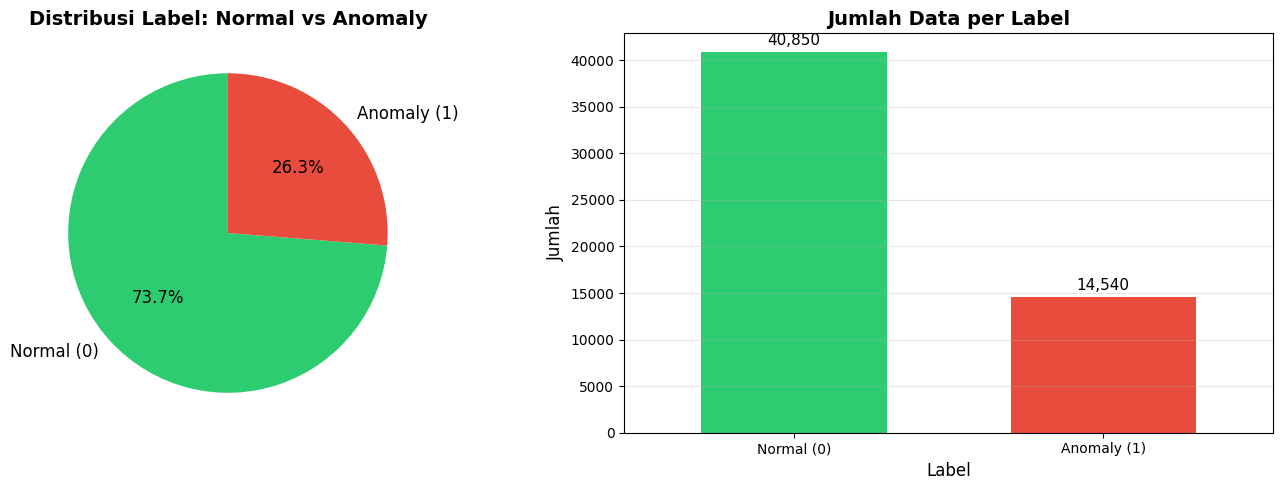

Total Normal: 40,850 (73.75%)
Total Anomaly: 14,540 (26.25%)


In [7]:
# ============================================================
# EDA 1: DISTRIBUSI LABEL (NORMAL vs ANOMALY)
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
label_counts = df_logs_clean['label'].value_counts()
labels_pie = ['Normal (0)', 'Anomaly (1)']
colors = ['#2ecc71', '#e74c3c']
axes[0].pie(label_counts.values, labels=labels_pie, autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 12})
axes[0].set_title('Distribusi Label: Normal vs Anomaly', fontsize=14, fontweight='bold')

# Bar chart
label_counts.plot(kind='bar', ax=axes[1], color=colors, width=0.6)
axes[1].set_title('Jumlah Data per Label', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Label', fontsize=12)
axes[1].set_ylabel('Jumlah', fontsize=12)
axes[1].set_xticklabels(['Normal (0)', 'Anomaly (1)'], rotation=0)
axes[1].grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for i, v in enumerate(label_counts.values):
    axes[1].text(i, v + 500, f'{v:,}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

print(f"Total Normal: {label_counts[0]:,} ({label_counts[0]/len(df_logs_clean)*100:.2f}%)")
print(f"Total Anomaly: {label_counts[1]:,} ({label_counts[1]/len(df_logs_clean)*100:.2f}%)")


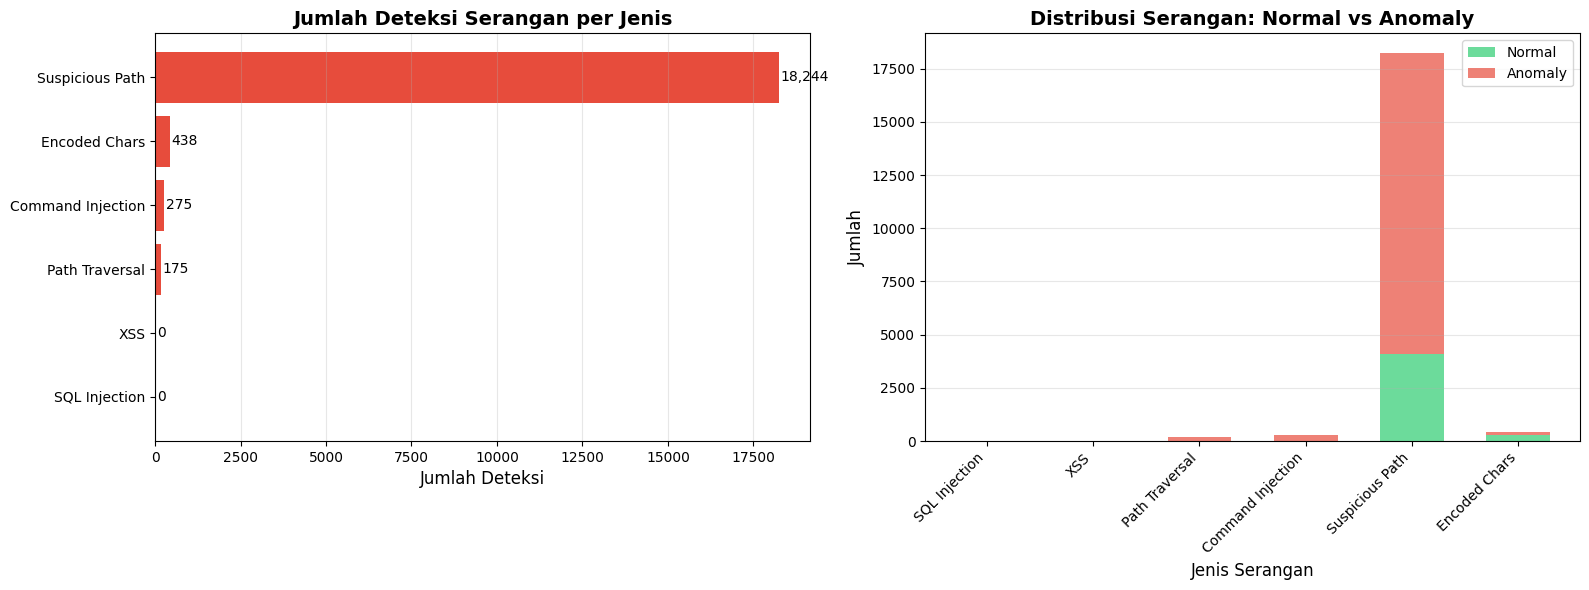

In [8]:
# ============================================================
# EDA 2: DISTRIBUSI FITUR KEAMANAN (ATTACK DETECTION)
# ============================================================

# Hitung jumlah deteksi untuk setiap jenis serangan
attack_features = {
    'SQL Injection': df_logs_clean['has_sql_injection'].sum(),
    'XSS': df_logs_clean['has_xss'].sum(),
    'Path Traversal': df_logs_clean['has_path_traversal'].sum(),
    'Command Injection': df_logs_clean['has_command_injection'].sum(),
    'Suspicious Path': df_logs_clean['is_suspicious_path'].sum(),
    'Encoded Chars': df_logs_clean['has_encoded_chars'].sum()
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart horizontal
attack_df = pd.DataFrame(list(attack_features.items()), columns=['Attack Type', 'Count'])
attack_df = attack_df.sort_values('Count', ascending=True)
axes[0].barh(attack_df['Attack Type'], attack_df['Count'], color='#e74c3c')
axes[0].set_title('Jumlah Deteksi Serangan per Jenis', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Jumlah Deteksi', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Tambahkan nilai di ujung bar
for i, v in enumerate(attack_df['Count']):
    axes[0].text(v + 50, i, f'{v:,}', va='center', fontsize=10)

# Stacked bar chart: Normal vs Anomaly untuk setiap jenis serangan
attack_cols = ['has_sql_injection', 'has_xss', 'has_path_traversal', 
               'has_command_injection', 'is_suspicious_path', 'has_encoded_chars']
attack_labels = ['SQL Injection', 'XSS', 'Path Traversal', 
                 'Command Injection', 'Suspicious Path', 'Encoded Chars']

normal_counts = [df_logs_clean[(df_logs_clean[col] == 1) & (df_logs_clean['label'] == 0)].shape[0] 
                 for col in attack_cols]
anomaly_counts = [df_logs_clean[(df_logs_clean[col] == 1) & (df_logs_clean['label'] == 1)].shape[0] 
                  for col in attack_cols]

x = np.arange(len(attack_labels))
width = 0.6
axes[1].bar(x, normal_counts, width, label='Normal', color='#2ecc71', alpha=0.7)
axes[1].bar(x, anomaly_counts, width, bottom=normal_counts, label='Anomaly', color='#e74c3c', alpha=0.7)
axes[1].set_title('Distribusi Serangan: Normal vs Anomaly', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Jenis Serangan', fontsize=12)
axes[1].set_ylabel('Jumlah', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(attack_labels, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


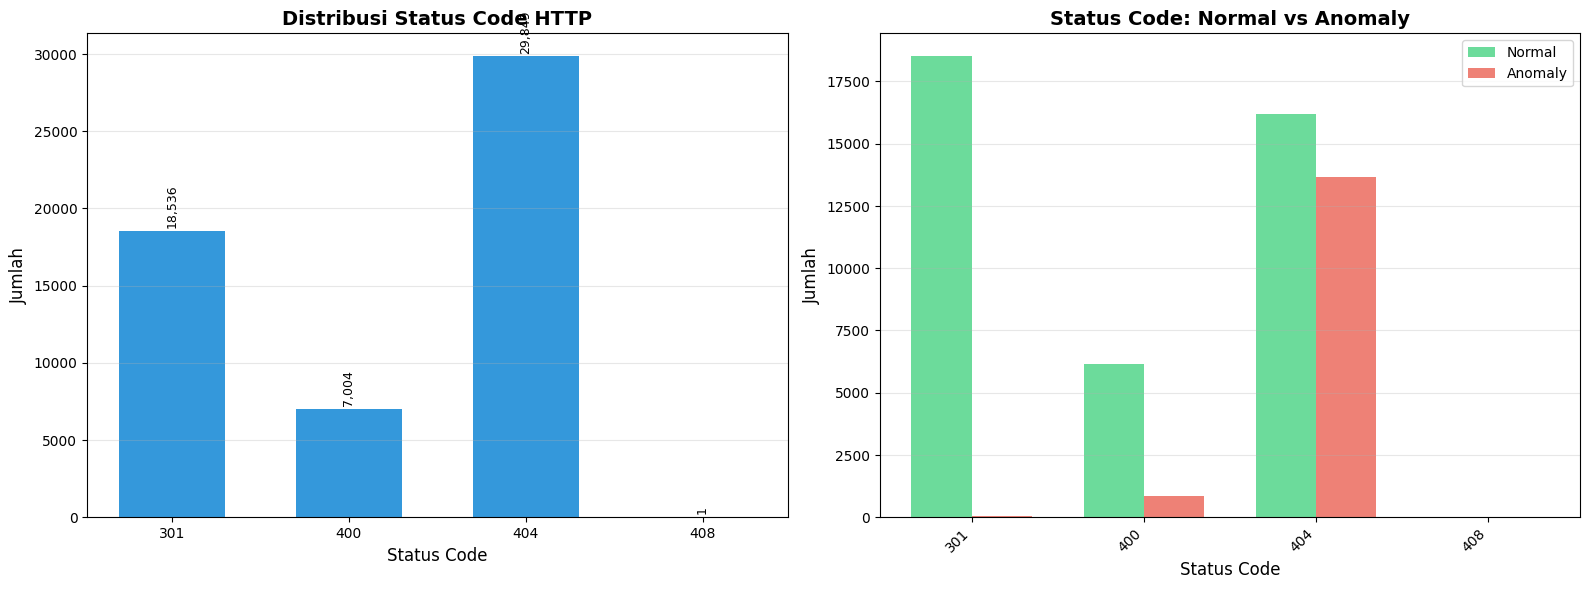

Top 10 Status Code:
status
301    18536
400     7004
404    29849
408        1
Name: count, dtype: int64


In [9]:
# ============================================================
# EDA 3: DISTRIBUSI STATUS CODE HTTP
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Status code distribution overall
status_counts = df_logs_clean['status'].value_counts().sort_index()
axes[0].bar(status_counts.index.astype(str), status_counts.values, color='#3498db', width=0.6)
axes[0].set_title('Distribusi Status Code HTTP', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Status Code', fontsize=12)
axes[0].set_ylabel('Jumlah', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar (hanya untuk top 10)
top_status = status_counts.head(10)
for status, count in top_status.items():
    axes[0].text(str(status), count + 200, f'{count:,}', ha='center', va='bottom', fontsize=9, rotation=90)

# Status code by label (Normal vs Anomaly)
status_normal = df_logs_clean[df_logs_clean['label'] == 0]['status'].value_counts().sort_index()
status_anomaly = df_logs_clean[df_logs_clean['label'] == 1]['status'].value_counts().sort_index()

# Gabungkan dan plot
all_status = sorted(set(status_normal.index) | set(status_anomaly.index))
normal_vals = [status_normal.get(s, 0) for s in all_status]
anomaly_vals = [status_anomaly.get(s, 0) for s in all_status]

x = np.arange(len(all_status))
width = 0.35
axes[1].bar(x - width/2, normal_vals, width, label='Normal', color='#2ecc71', alpha=0.7)
axes[1].bar(x + width/2, anomaly_vals, width, label='Anomaly', color='#e74c3c', alpha=0.7)
axes[1].set_title('Status Code: Normal vs Anomaly', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Status Code', fontsize=12)
axes[1].set_ylabel('Jumlah', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels([str(s) for s in all_status], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Tampilkan statistik
print("Top 10 Status Code:")
print(status_counts.head(10))


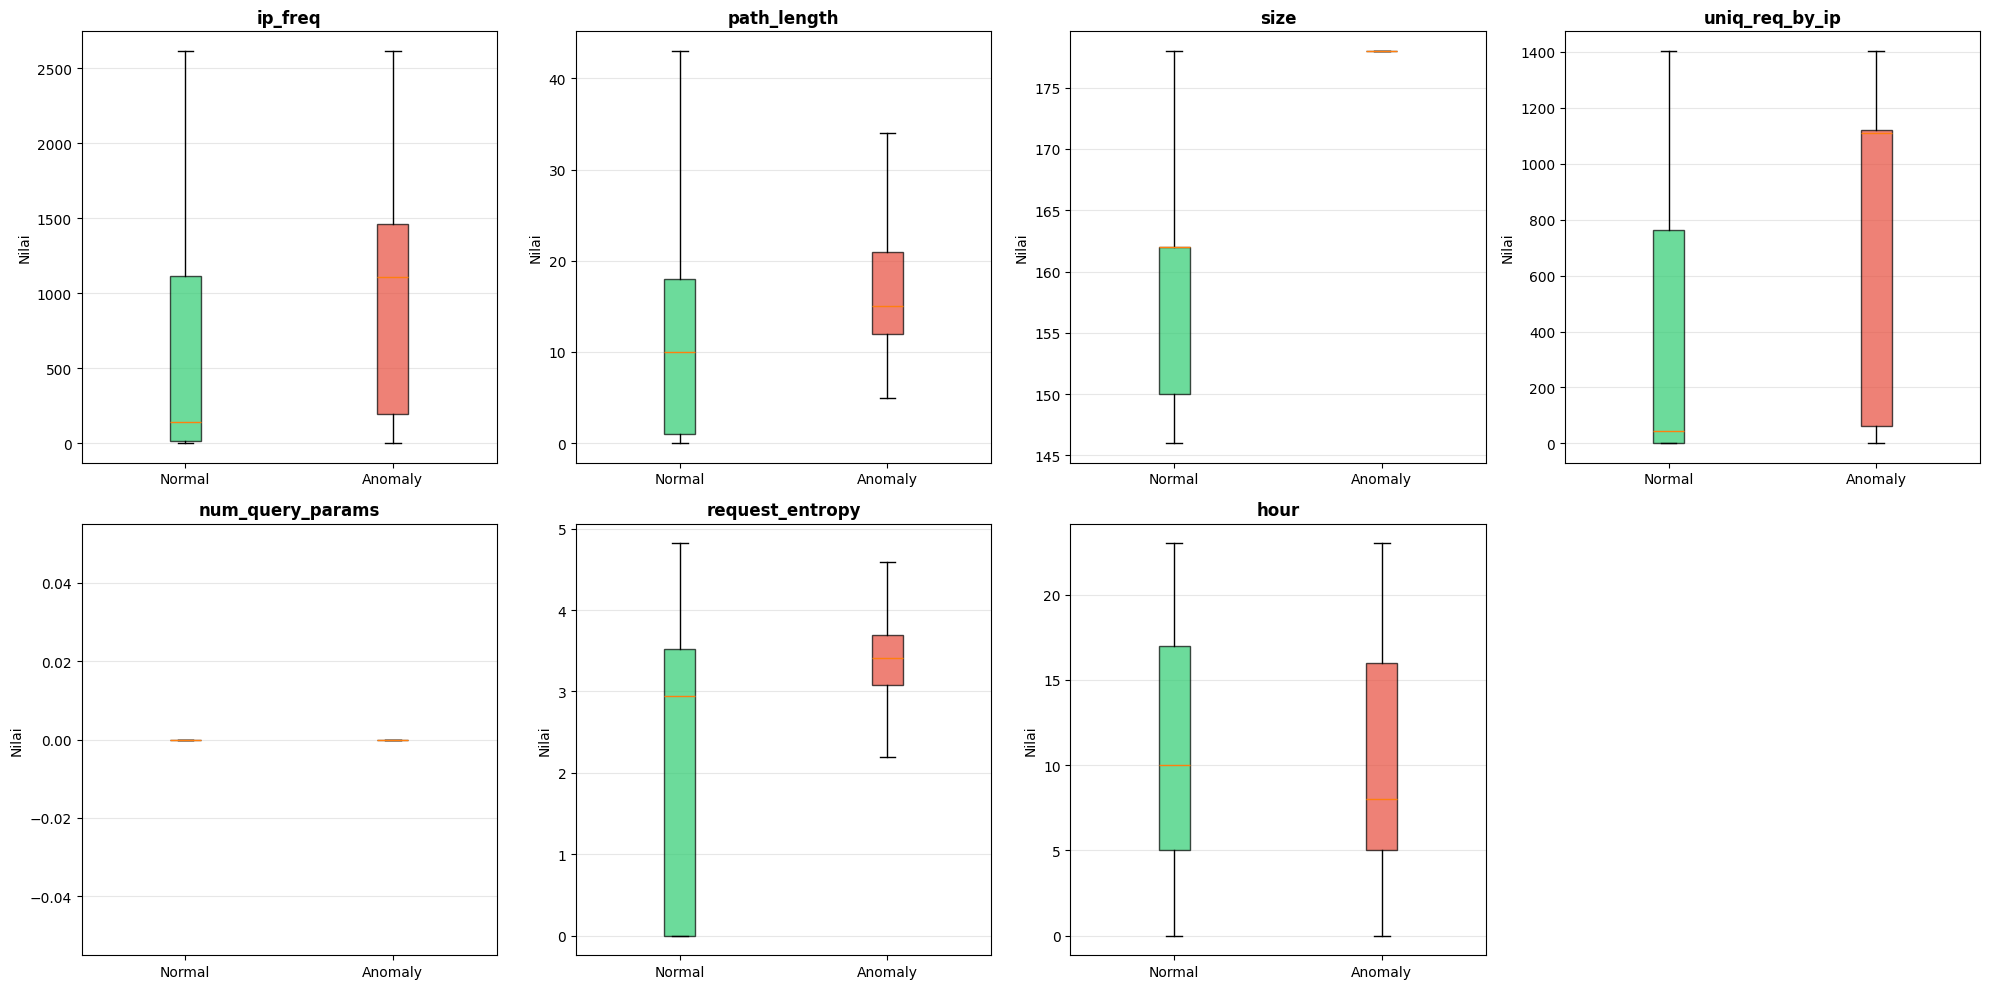

In [10]:
# ============================================================
# EDA 4: DISTRIBUSI FITUR NUMERIK (BOX PLOT & HISTOGRAM)
# ============================================================

# Pilih fitur numerik untuk dianalisis
numeric_features = ['ip_freq', 'path_length', 'size', 'uniq_req_by_ip', 
                    'num_query_params', 'request_entropy', 'hour']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    # Box plot
    data_normal = df_logs_clean[df_logs_clean['label'] == 0][feature]
    data_anomaly = df_logs_clean[df_logs_clean['label'] == 1][feature]
    
    bp = axes[i].boxplot([data_normal, data_anomaly], 
                         labels=['Normal', 'Anomaly'],
                         patch_artist=True,
                         showfliers=False)  # Hide outliers untuk clarity
    
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_facecolor('#e74c3c')
    bp['boxes'][1].set_alpha(0.7)
    
    axes[i].set_title(f'{feature}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Nilai', fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)

# Hapus subplot terakhir yang tidak digunakan
axes[7].remove()

plt.tight_layout()
plt.show()

# # Statistik deskriptif
# print("\nStatistik Deskriptif Fitur Numerik (Normal):")
# print(df_logs_clean[df_logs_clean['label'] == 0][numeric_features].describe())
# print("\nStatistik Deskriptif Fitur Numerik (Anomaly):")
# print(df_logs_clean[df_logs_clean['label'] == 1][numeric_features].describe())


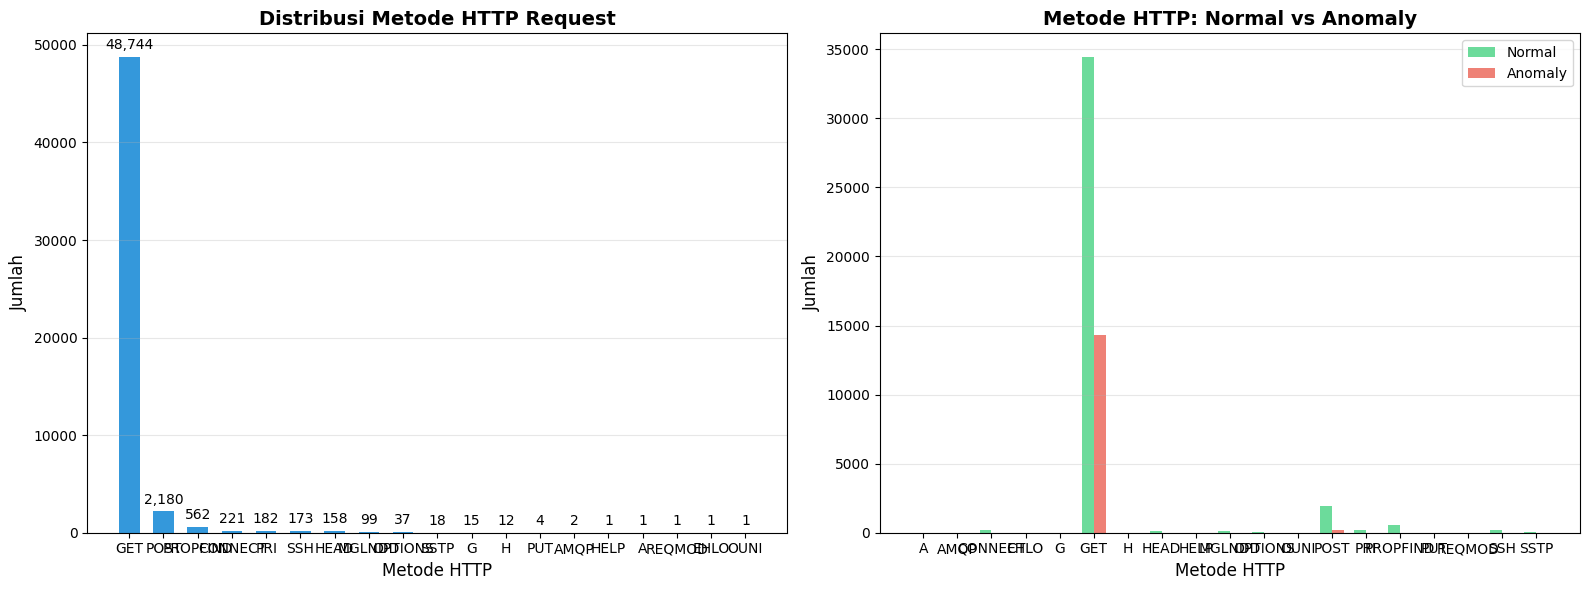


Distribusi Metode HTTP:
method
GET         48744
POST         2180
PROPFIND      562
CONNECT       221
PRI           182
SSH           173
HEAD          158
MGLNDD         99
OPTIONS        37
SSTP           18
G              15
H              12
PUT             4
AMQP            2
HELP            1
A               1
REQMOD          1
EHLO            1
OUNI            1
Name: count, dtype: int64


In [11]:
# ============================================================
# EDA 5: DISTRIBUSI METODE HTTP REQUEST
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribusi metode HTTP overall
method_counts = df_logs_clean['method'].value_counts()
axes[0].bar(method_counts.index, method_counts.values, color='#3498db', width=0.6)
axes[0].set_title('Distribusi Metode HTTP Request', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Metode HTTP', fontsize=12)
axes[0].set_ylabel('Jumlah', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for i, (method, count) in enumerate(method_counts.items()):
    axes[0].text(i, count + 500, f'{count:,}', ha='center', va='bottom', fontsize=10)

# Metode HTTP by label
method_normal = df_logs_clean[df_logs_clean['label'] == 0]['method'].value_counts()
method_anomaly = df_logs_clean[df_logs_clean['label'] == 1]['method'].value_counts()

all_methods = sorted(set(method_normal.index) | set(method_anomaly.index))
normal_vals = [method_normal.get(m, 0) for m in all_methods]
anomaly_vals = [method_anomaly.get(m, 0) for m in all_methods]

x = np.arange(len(all_methods))
width = 0.35
axes[1].bar(x - width/2, normal_vals, width, label='Normal', color='#2ecc71', alpha=0.7)
axes[1].bar(x + width/2, anomaly_vals, width, label='Anomaly', color='#e74c3c', alpha=0.7)
axes[1].set_title('Metode HTTP: Normal vs Anomaly', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Metode HTTP', fontsize=12)
axes[1].set_ylabel('Jumlah', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(all_methods, rotation=0)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDistribusi Metode HTTP:")
print(method_counts)


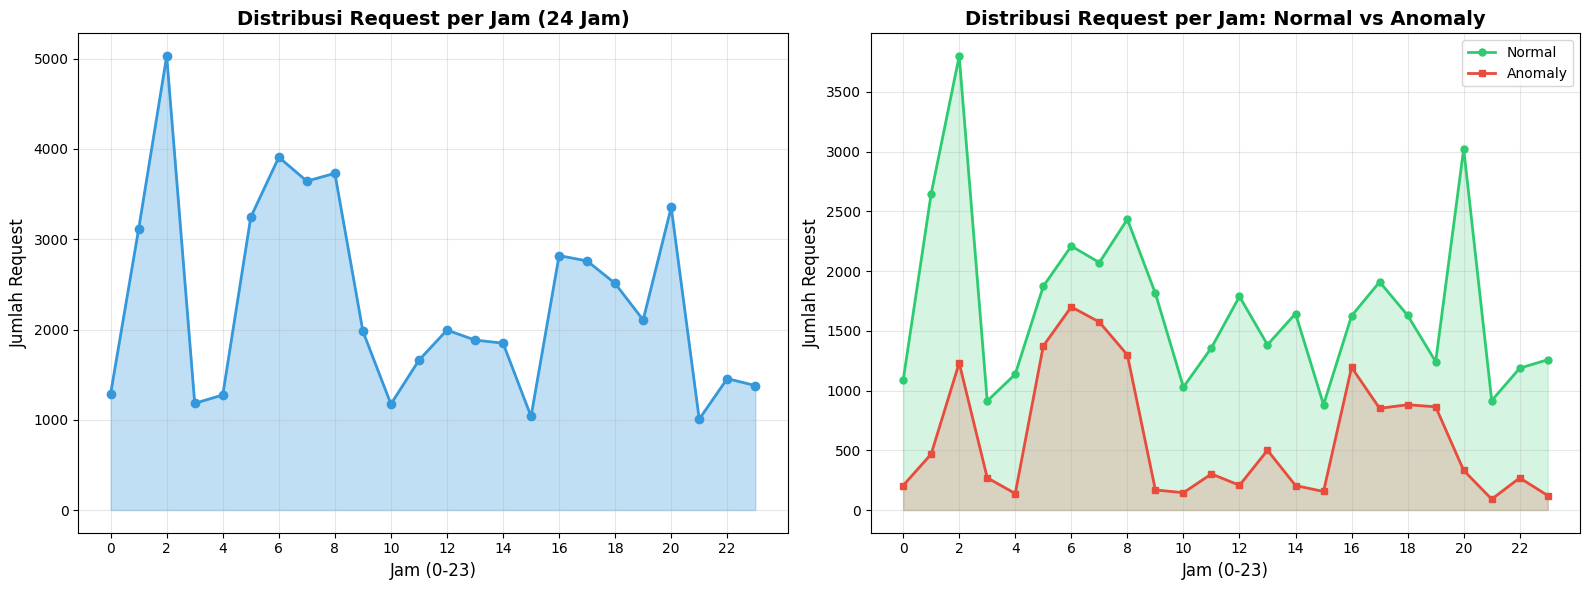


Top 5 Jam dengan Anomaly Tertinggi:
Jam 06:00 - 1,700 anomaly
Jam 07:00 - 1,573 anomaly
Jam 05:00 - 1,373 anomaly
Jam 08:00 - 1,298 anomaly
Jam 02:00 - 1,231 anomaly


In [12]:
# ============================================================
# EDA 6: ANALISIS TEMPORAL (DISTRIBUSI PER JAM)
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribusi per jam (overall)
hour_counts = df_logs_clean['hour'].value_counts().sort_index()
axes[0].plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2, markersize=6, color='#3498db')
axes[0].fill_between(hour_counts.index, hour_counts.values, alpha=0.3, color='#3498db')
axes[0].set_title('Distribusi Request per Jam (24 Jam)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Jam (0-23)', fontsize=12)
axes[0].set_ylabel('Jumlah Request', fontsize=12)
axes[0].set_xticks(range(0, 24, 2))
axes[0].grid(True, alpha=0.3)

# Distribusi per jam: Normal vs Anomaly
hour_normal = df_logs_clean[df_logs_clean['label'] == 0]['hour'].value_counts().sort_index()
hour_anomaly = df_logs_clean[df_logs_clean['label'] == 1]['hour'].value_counts().sort_index()

# Pastikan semua jam (0-23) ada
all_hours = range(24)
normal_vals = [hour_normal.get(h, 0) for h in all_hours]
anomaly_vals = [hour_anomaly.get(h, 0) for h in all_hours]

axes[1].plot(all_hours, normal_vals, marker='o', linewidth=2, markersize=5, 
             label='Normal', color='#2ecc71')
axes[1].plot(all_hours, anomaly_vals, marker='s', linewidth=2, markersize=5, 
             label='Anomaly', color='#e74c3c')
axes[1].fill_between(all_hours, normal_vals, alpha=0.2, color='#2ecc71')
axes[1].fill_between(all_hours, anomaly_vals, alpha=0.2, color='#e74c3c')
axes[1].set_title('Distribusi Request per Jam: Normal vs Anomaly', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Jam (0-23)', fontsize=12)
axes[1].set_ylabel('Jumlah Request', fontsize=12)
axes[1].set_xticks(range(0, 24, 2))
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Jam dengan anomaly tertinggi
print("\nTop 5 Jam dengan Anomaly Tertinggi:")
top_anomaly_hours = pd.Series(anomaly_vals, index=all_hours).sort_values(ascending=False).head(5)
for hour, count in top_anomaly_hours.items():
    print(f"Jam {hour:02d}:00 - {count:,} anomaly")


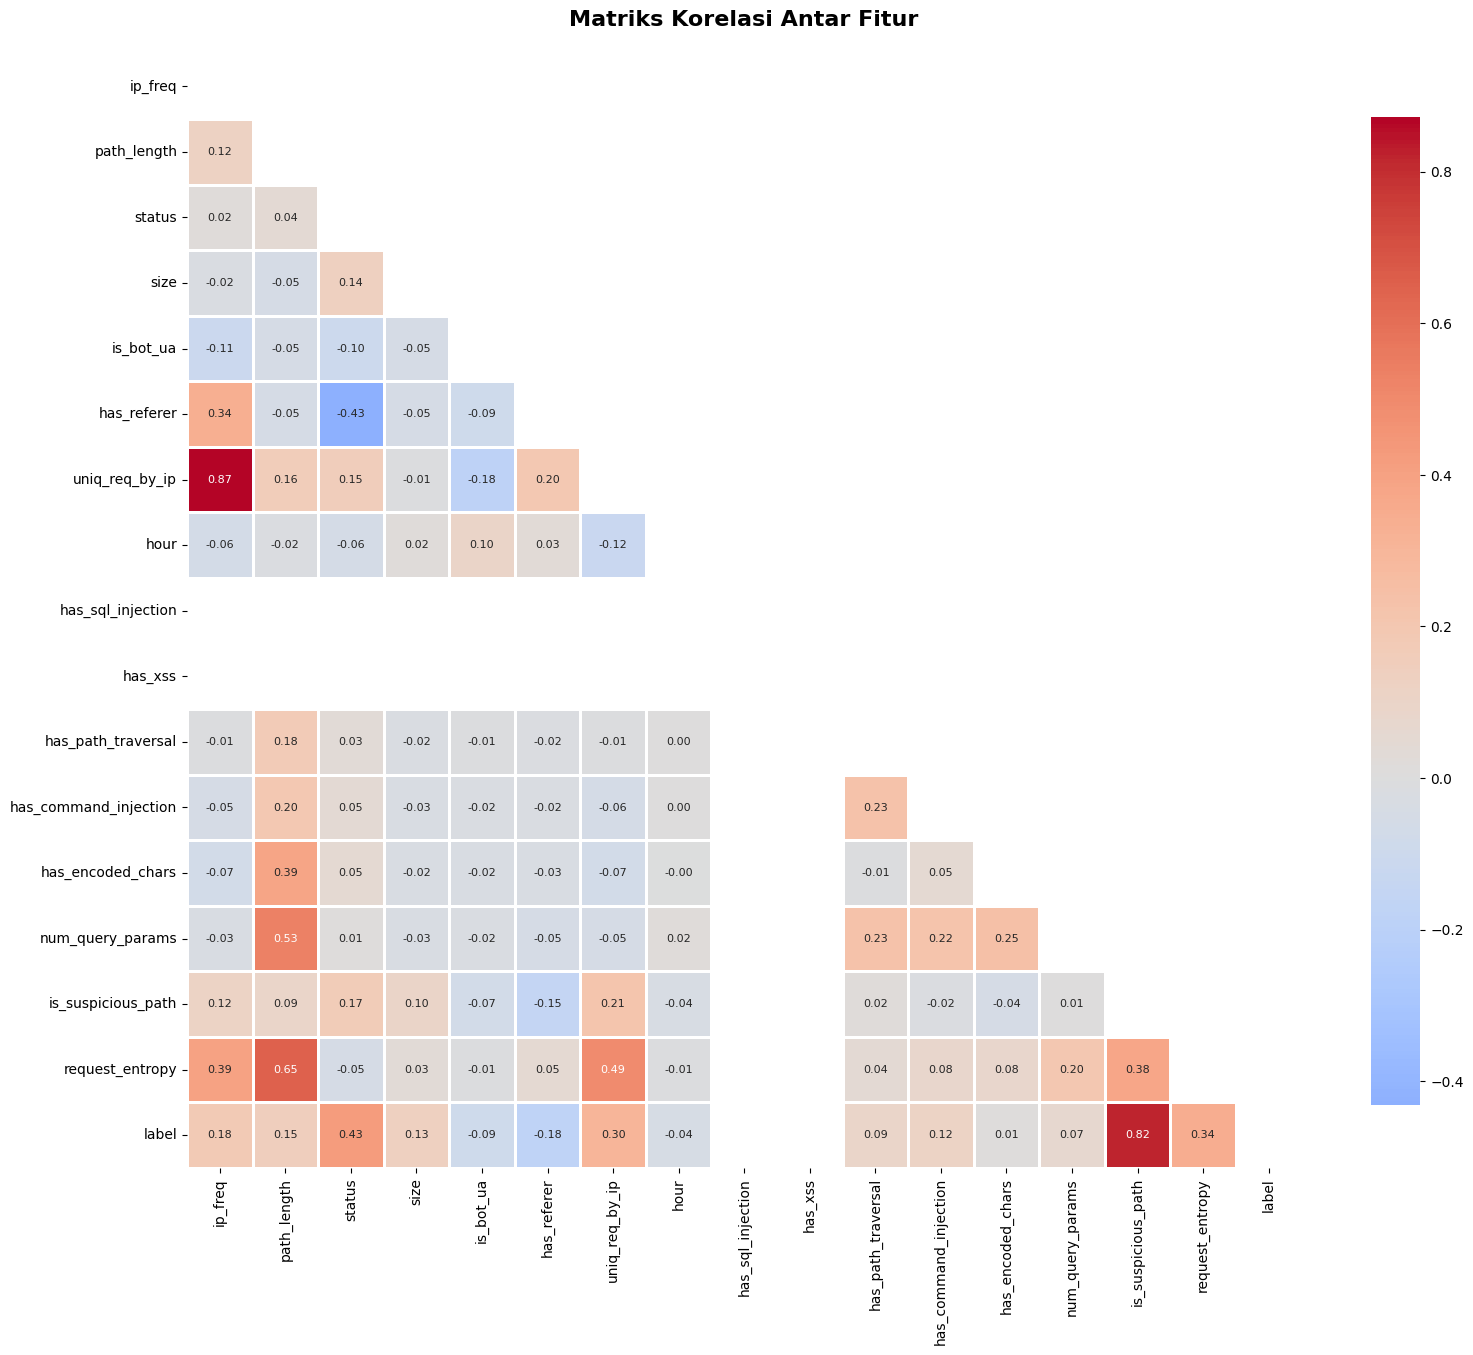


Top 10 Fitur dengan Korelasi Tertinggi terhadap Label:
is_suspicious_path       : 0.8175
status                   : 0.4267
request_entropy          : 0.3449
uniq_req_by_ip           : 0.3048
ip_freq                  : 0.1844
has_referer              : 0.1794
path_length              : 0.1462
size                     : 0.1349
has_command_injection    : 0.1184
has_path_traversal       : 0.0944


In [13]:
# ============================================================
# EDA 7: KORELASI ANTAR FITUR
# ============================================================

# Pilih fitur numerik untuk korelasi
correlation_features = ['ip_freq', 'path_length', 'status', 'size', 
                        'is_bot_ua', 'has_referer', 'uniq_req_by_ip', 'hour',
                        'has_sql_injection', 'has_xss', 'has_path_traversal',
                        'has_command_injection', 'has_encoded_chars', 
                        'num_query_params', 'is_suspicious_path', 
                        'request_entropy', 'label']

# Hitung matriks korelasi
corr_matrix = df_logs_clean[correlation_features].corr()

# Plot heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            annot_kws={'size': 8})
plt.title('Matriks Korelasi Antar Fitur', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Tampilkan korelasi tertinggi dengan label
print("\nTop 10 Fitur dengan Korelasi Tertinggi terhadap Label:")
label_corr = corr_matrix['label'].drop('label').abs().sort_values(ascending=False).head(10)
for feature, corr in label_corr.items():
    print(f"{feature:25s}: {corr:.4f}")


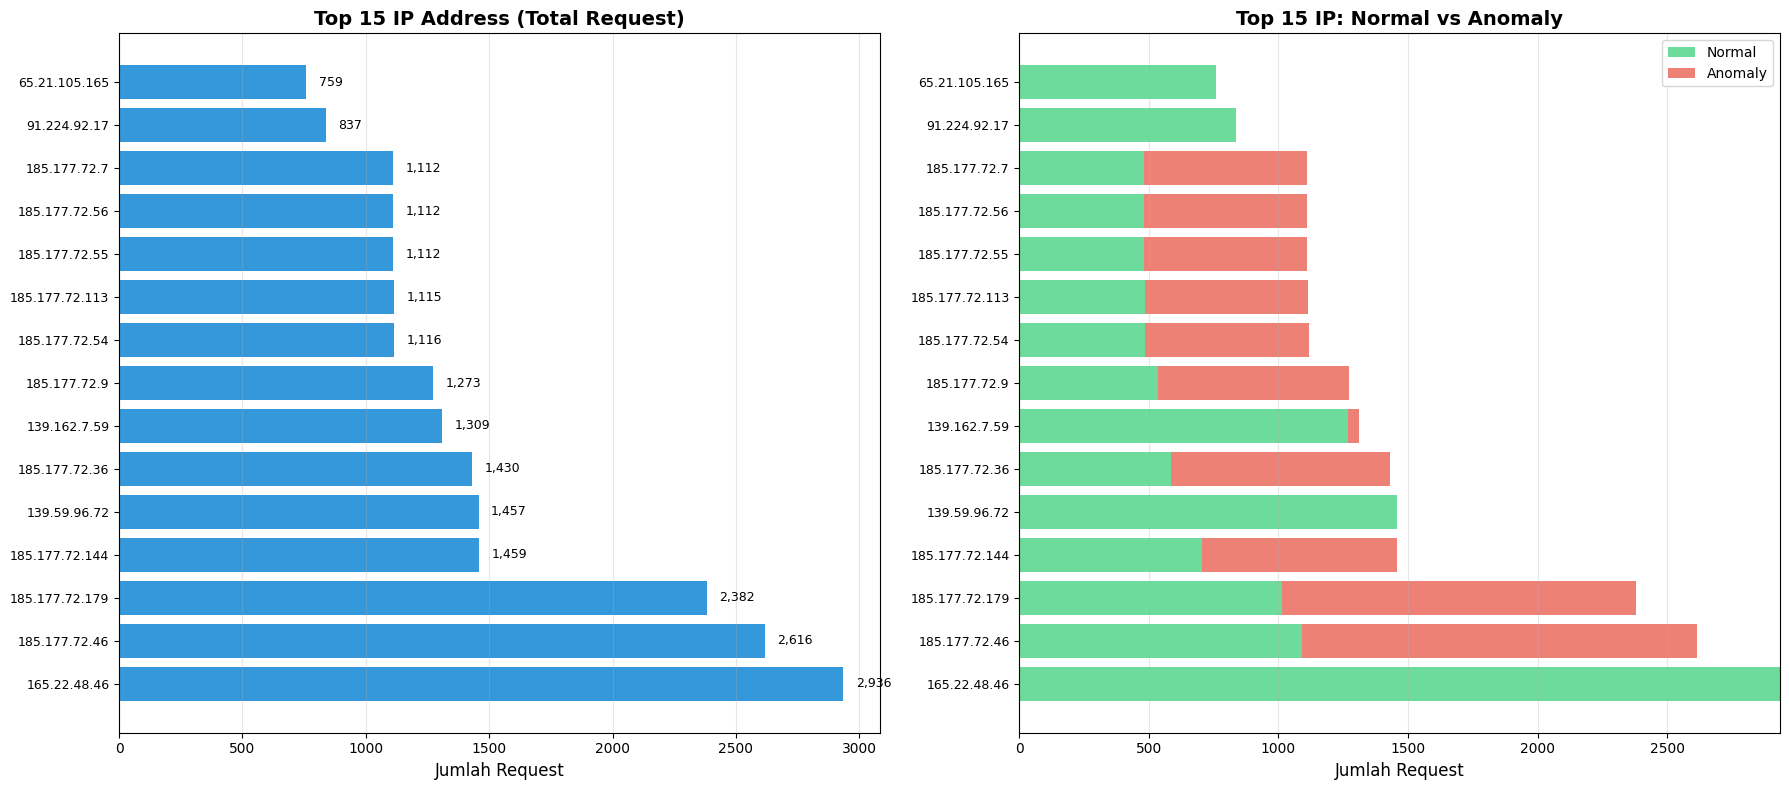


Top 5 IP dengan Anomaly Tertinggi:
185.177.72.46       : 1,524 anomaly dari 2,616 total (58.3%)
185.177.72.179      : 1,367 anomaly dari 2,382 total (57.4%)
185.177.72.36       : 846 anomaly dari 1,430 total (59.2%)
185.177.72.144      : 755 anomaly dari 1,459 total (51.7%)
185.177.72.9        : 738 anomaly dari 1,273 total (58.0%)


In [14]:
# ============================================================
# EDA 8: TOP IP ADDRESS (NORMAL vs ANOMALY)
# ============================================================

# Top 15 IP dengan request terbanyak
top_ips = df_logs_clean['ip'].value_counts().head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Bar chart: Top IP overall
axes[0].barh(range(len(top_ips)), top_ips.values, color='#3498db')
axes[0].set_yticks(range(len(top_ips)))
axes[0].set_yticklabels(top_ips.index, fontsize=9)
axes[0].set_xlabel('Jumlah Request', fontsize=12)
axes[0].set_title('Top 15 IP Address (Total Request)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Tambahkan nilai
for i, v in enumerate(top_ips.values):
    axes[0].text(v + 50, i, f'{v:,}', va='center', fontsize=9)

# Stacked bar: Normal vs Anomaly untuk top IP
ip_labels = top_ips.index
normal_counts = [df_logs_clean[(df_logs_clean['ip'] == ip) & (df_logs_clean['label'] == 0)].shape[0] 
                 for ip in ip_labels]
anomaly_counts = [df_logs_clean[(df_logs_clean['ip'] == ip) & (df_logs_clean['label'] == 1)].shape[0] 
                  for ip in ip_labels]

y_pos = np.arange(len(ip_labels))
axes[1].barh(y_pos, normal_counts, label='Normal', color='#2ecc71', alpha=0.7)
axes[1].barh(y_pos, anomaly_counts, left=normal_counts, label='Anomaly', color='#e74c3c', alpha=0.7)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(ip_labels, fontsize=9)
axes[1].set_xlabel('Jumlah Request', fontsize=12)
axes[1].set_title('Top 15 IP: Normal vs Anomaly', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistik
print("\nTop 5 IP dengan Anomaly Tertinggi:")
top_anomaly_ips = df_logs_clean[df_logs_clean['label'] == 1]['ip'].value_counts().head(5)
for ip, count in top_anomaly_ips.items():
    total = df_logs_clean[df_logs_clean['ip'] == ip].shape[0]
    pct = (count / total) * 100
    print(f"{ip:20s}: {count:,} anomaly dari {total:,} total ({pct:.1f}%)")


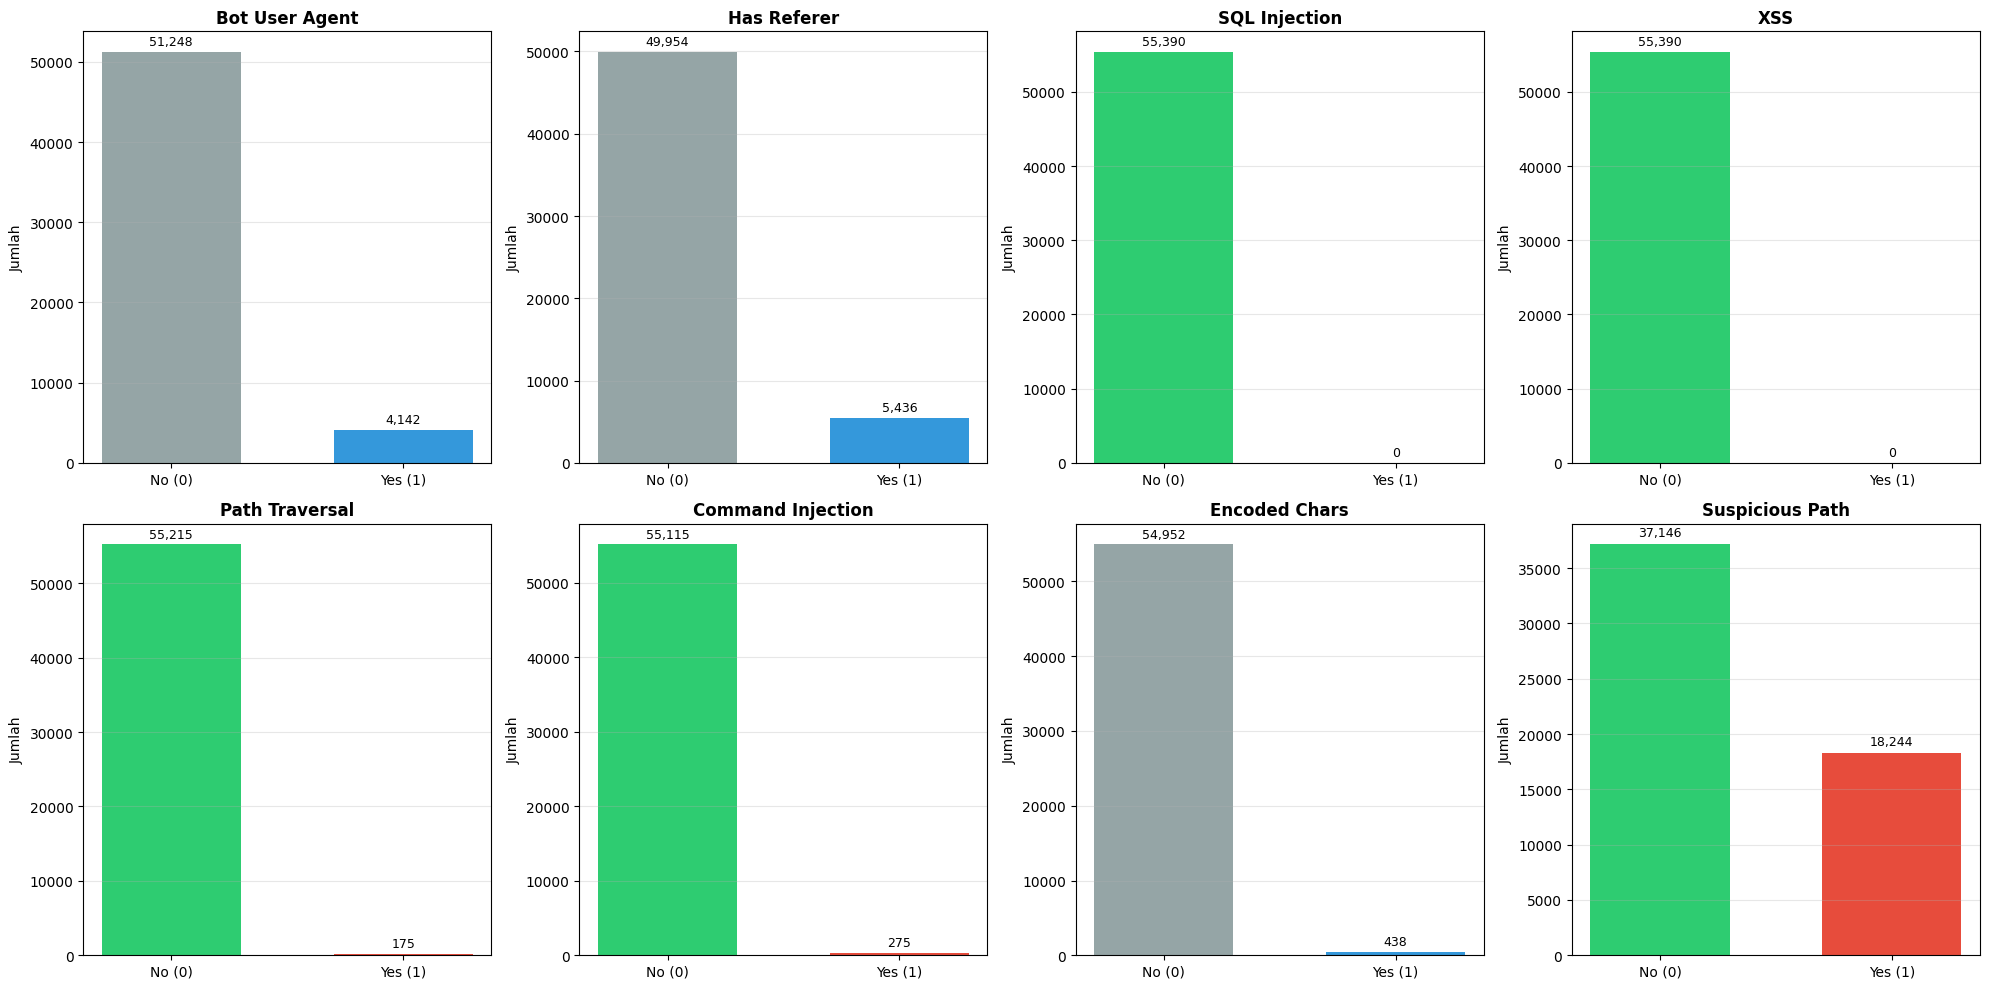


Persentase Fitur Binary (Yes = 1):
Bot User Agent           :   7.48%
Has Referer              :   9.81%
SQL Injection            :   0.00%
XSS                      :   0.00%
Path Traversal           :   0.32%
Command Injection        :   0.50%
Encoded Chars            :   0.79%
Suspicious Path          :  32.94%


In [15]:
# ============================================================
# EDA 9: DISTRIBUSI FITUR BINARY (BOT, REFERER, dll)
# ============================================================

binary_features = {
    'is_bot_ua': 'Bot User Agent',
    'has_referer': 'Has Referer',
    'has_sql_injection': 'SQL Injection',
    'has_xss': 'XSS',
    'has_path_traversal': 'Path Traversal',
    'has_command_injection': 'Command Injection',
    'has_encoded_chars': 'Encoded Chars',
    'is_suspicious_path': 'Suspicious Path'
}

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (col, title) in enumerate(binary_features.items()):
    # Hitung distribusi
    counts = df_logs_clean[col].value_counts().sort_index()
    labels = ['No (0)', 'Yes (1)']
    
    # Warna berbeda untuk normal vs anomaly
    if col in ['has_sql_injection', 'has_xss', 'has_path_traversal', 
               'has_command_injection', 'is_suspicious_path']:
        colors = ['#2ecc71', '#e74c3c']
    else:
        colors = ['#95a5a6', '#3498db']
    
    axes[i].bar(labels, [counts.get(0, 0), counts.get(1, 0)], color=colors, width=0.6)
    axes[i].set_title(title, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Jumlah', fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)
    
    # Tambahkan nilai
    for j, v in enumerate([counts.get(0, 0), counts.get(1, 0)]):
        axes[i].text(j, v + 500, f'{v:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Persentase untuk setiap fitur binary
print("\nPersentase Fitur Binary (Yes = 1):")
for col, title in binary_features.items():
    pct = (df_logs_clean[col] == 1).sum() / len(df_logs_clean) * 100
    print(f"{title:25s}: {pct:6.2f}%")


In [28]:
# # ============================================================
# # EDA 10: DISTRIBUSI SIZE (RESPONSE SIZE) - NORMAL vs ANOMALY
# # ============================================================

# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# # Histogram dengan log scale (karena size bisa sangat bervariasi)
# size_normal = df_logs_clean[df_logs_clean['label'] == 0]['size']
# size_anomaly = df_logs_clean[df_logs_clean['label'] == 1]['size']

# # Filter nilai 0 dan gunakan log scale
# size_normal_log = np.log1p(size_normal[size_normal > 0])
# size_anomaly_log = np.log1p(size_anomaly[size_anomaly > 0])

# axes[0].hist(size_normal_log, bins=50, alpha=0.7, label='Normal', color='#2ecc71', density=True)
# axes[0].hist(size_anomaly_log, bins=50, alpha=0.7, label='Anomaly', color='#e74c3c', density=True)
# axes[0].set_title('Distribusi Response Size (Log Scale)', fontsize=14, fontweight='bold')
# axes[0].set_xlabel('Log(Size + 1)', fontsize=12)
# axes[0].set_ylabel('Density', fontsize=12)
# axes[0].legend()
# axes[0].grid(alpha=0.3)

# # Box plot untuk size (dengan outlier handling)
# size_data = [size_normal[size_normal <= size_normal.quantile(0.95)], 
#              size_anomaly[size_anomaly <= size_anomaly.quantile(0.95)]]

# bp = axes[1].boxplot(size_data, labels=['Normal', 'Anomaly'], patch_artist=True, showfliers=False)
# bp['boxes'][0].set_facecolor('#2ecc71')
# bp['boxes'][0].set_alpha(0.7)
# bp['boxes'][1].set_facecolor('#e74c3c')
# bp['boxes'][1].set_alpha(0.7)

# axes[1].set_title('Response Size Distribution (95th percentile)', fontsize=14, fontweight='bold')
# axes[1].set_ylabel('Size (bytes)', fontsize=12)
# axes[1].grid(axis='y', alpha=0.3)

# plt.tight_layout()
# plt.show()

# # Statistik
# print("\nStatistik Response Size:")
# print(f"Normal  - Mean: {size_normal.mean():,.0f}, Median: {size_normal.median():,.0f}, Std: {size_normal.std():,.0f}")
# print(f"Anomaly - Mean: {size_anomaly.mean():,.0f}, Median: {size_anomaly.median():,.0f}, Std: {size_anomaly.std():,.0f}")


In [29]:
# # ============================================================
# # EDA 11: RINGKASAN STATISTIK & INSIGHTS
# # ============================================================

# print("=" * 70)
# print("RINGKASAN EKSPLORASI DATA (EDA)")
# print("=" * 70)

# print("\n1. OVERVIEW DATA:")
# print(f"   - Total records: {len(df_logs_clean):,}")
# print(f"   - Normal: {len(df_logs_clean[df_logs_clean['label'] == 0]):,} ({len(df_logs_clean[df_logs_clean['label'] == 0])/len(df_logs_clean)*100:.2f}%)")
# print(f"   - Anomaly: {len(df_logs_clean[df_logs_clean['label'] == 1]):,} ({len(df_logs_clean[df_logs_clean['label'] == 1])/len(df_logs_clean)*100:.2f}%)")

# print("\n2. DETEKSI SERANGAN LANGSUNG:")
# attack_detections = {
#     'SQL Injection': df_logs_clean['has_sql_injection'].sum(),
#     'XSS': df_logs_clean['has_xss'].sum(),
#     'Path Traversal': df_logs_clean['has_path_traversal'].sum(),
#     'Command Injection': df_logs_clean['has_command_injection'].sum()
# }
# for attack, count in attack_detections.items():
#     print(f"   - {attack:20s}: {count:6,} ({count/len(df_logs_clean)*100:.2f}%)")

# print("\n3. STATUS CODE:")
# status_4xx = len(df_logs_clean[df_logs_clean['status'].between(400, 499)])
# status_5xx = len(df_logs_clean[df_logs_clean['status'].between(500, 599)])
# print(f"   - 4xx (Client Error): {status_4xx:,} ({status_4xx/len(df_logs_clean)*100:.2f}%)")
# print(f"   - 5xx (Server Error): {status_5xx:,} ({status_5xx/len(df_logs_clean)*100:.2f}%)")
# print(f"   - Status code paling umum: {df_logs_clean['status'].mode()[0]} ({df_logs_clean['status'].value_counts().iloc[0]:,} kali)")

# print("\n4. METODE HTTP:")
# method_counts = df_logs_clean['method'].value_counts()
# for method, count in method_counts.head(5).items():
#     print(f"   - {method:10s}: {count:6,} ({count/len(df_logs_clean)*100:.2f}%)")

# print("\n5. FITUR BINARY:")
# print(f"   - Bot User Agent: {(df_logs_clean['is_bot_ua'] == 1).sum():,} ({(df_logs_clean['is_bot_ua'] == 1).sum()/len(df_logs_clean)*100:.2f}%)")
# print(f"   - Has Referer: {(df_logs_clean['has_referer'] == 1).sum():,} ({(df_logs_clean['has_referer'] == 1).sum()/len(df_logs_clean)*100:.2f}%)")
# print(f"   - Suspicious Path: {(df_logs_clean['is_suspicious_path'] == 1).sum():,} ({(df_logs_clean['is_suspicious_path'] == 1).sum()/len(df_logs_clean)*100:.2f}%)")
# print(f"   - Encoded Chars: {(df_logs_clean['has_encoded_chars'] == 1).sum():,} ({(df_logs_clean['has_encoded_chars'] == 1).sum()/len(df_logs_clean)*100:.2f}%)")

# print("\n6. STATISTIK NUMERIK:")
# print(f"   - IP Frequency - Mean: {df_logs_clean['ip_freq'].mean():.2f}, Max: {df_logs_clean['ip_freq'].max():,}")
# print(f"   - Path Length - Mean: {df_logs_clean['path_length'].mean():.2f}, Max: {df_logs_clean['path_length'].max():,}")
# print(f"   - Response Size - Mean: {df_logs_clean['size'].mean():,.0f}, Max: {df_logs_clean['size'].max():,}")
# print(f"   - Request Entropy - Mean: {df_logs_clean['request_entropy'].mean():.2f}, Max: {df_logs_clean['request_entropy'].max():.2f}")
# print(f"   - Query Params - Mean: {df_logs_clean['num_query_params'].mean():.2f}, Max: {df_logs_clean['num_query_params'].max()}")

# print("\n7. TEMPORAL:")
# hour_peak = df_logs_clean['hour'].mode()[0]
# print(f"   - Jam dengan request terbanyak: {hour_peak:02d}:00")
# hour_anomaly_peak = df_logs_clean[df_logs_clean['label'] == 1]['hour'].mode()[0]
# print(f"   - Jam dengan anomaly terbanyak: {hour_anomaly_peak:02d}:00")

# print("\n8. TOP IP:")
# top_ip = df_logs_clean['ip'].value_counts().index[0]
# top_ip_count = df_logs_clean['ip'].value_counts().iloc[0]
# top_ip_anomaly = df_logs_clean[(df_logs_clean['ip'] == top_ip) & (df_logs_clean['label'] == 1)].shape[0]
# print(f"   - IP dengan request terbanyak: {top_ip} ({top_ip_count:,} requests)")
# print(f"   - Anomaly dari IP tersebut: {top_ip_anomaly:,} ({top_ip_anomaly/top_ip_count*100:.1f}%)")

# print("\n" + "=" * 70)


In [17]:
# ============================================================
# PREPROCESSING DATA UNTUK PEMODELAN
# ============================================================

# Siapkan data untuk modeling dan kelompokkan fitur sesuai perlakuan normalisasi
modeling_features = [
    'ip_freq',
    'path_length',
    'status',
    'size',
    'is_bot_ua',
    'has_referer',
    'uniq_req_by_ip',
    'hour',
    'has_sql_injection',
    'has_xss',
    'has_path_traversal',
    'has_command_injection',
    'has_encoded_chars',
    'num_query_params',
    'is_suspicious_path',
    'request_entropy',
    'method'
]

# Ekstrak fitur dan target
X = df_logs_clean[modeling_features].copy()
y = df_logs_clean['label'].copy()

# Handle missing values (jika ada)
print("Checking for missing values:")
print(X.isnull().sum())
print()

# Kelompok fitur untuk preprocessing
numeric_features = [
    'ip_freq',
    'path_length',
    'status',
    'size',
    'uniq_req_by_ip',
    'hour',
    'num_query_params',
    'request_entropy'
]

binary_features = [
    'is_bot_ua',
    'has_referer',
    'has_sql_injection',
    'has_xss',
    'has_path_traversal',
    'has_command_injection',
    'has_encoded_chars',
    'is_suspicious_path'
]

categorical_features = ['method']

print("Feature groups:")
print(f"  Numeric      : {numeric_features}")
print(f"  Binary       : {binary_features}")
print(f"  Categorical  : {categorical_features}")

print(f"\nShape X: {X.shape}")
print(f"Shape y: {y.shape}")
print(f"Total base features: {len(modeling_features)}")


Checking for missing values:
ip_freq                     0
path_length                 0
status                      0
size                        0
is_bot_ua                   0
has_referer                 0
uniq_req_by_ip              0
hour                        0
has_sql_injection           0
has_xss                     0
has_path_traversal          0
has_command_injection       0
has_encoded_chars           0
num_query_params            0
is_suspicious_path          0
request_entropy             0
method                   2978
dtype: int64

Feature groups:
  Numeric      : ['ip_freq', 'path_length', 'status', 'size', 'uniq_req_by_ip', 'hour', 'num_query_params', 'request_entropy']
  Binary       : ['is_bot_ua', 'has_referer', 'has_sql_injection', 'has_xss', 'has_path_traversal', 'has_command_injection', 'has_encoded_chars', 'is_suspicious_path']
  Categorical  : ['method']

Shape X: (55390, 17)
Shape y: (55390,)
Total base features: 17


In [18]:
# ============================================================
# SPLIT DATA: TRAIN & TEST
# ============================================================

# Split data menjadi train dan test set
# Stratified split untuk menjaga proporsi label
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("=" * 60)
print("DATA SPLIT INFORMATION")
print("=" * 60)
print(f"Total data: {len(X):,}")
print(f"Train set: {len(X_train):,} ({len(X_train)/len(X)*100:.2f}%)")
print(f"Test set: {len(X_test):,} ({len(X_test)/len(X)*100:.2f}%)")
print()

print("Train set label distribution:")
print(f"  Normal (0): {sum(y_train == 0):,} ({sum(y_train == 0)/len(y_train)*100:.2f}%)")
print(f"  Anomaly (1): {sum(y_train == 1):,} ({sum(y_train == 1)/len(y_train)*100:.2f}%)")
print()

print("Test set label distribution:")
print(f"  Normal (0): {sum(y_test == 0):,} ({sum(y_test == 0)/len(y_test)*100:.2f}%)")
print(f"  Anomaly (1): {sum(y_test == 1):,} ({sum(y_test == 1)/len(y_test)*100:.2f}%)")


DATA SPLIT INFORMATION
Total data: 55,390
Train set: 44,312 (80.00%)
Test set: 11,078 (20.00%)

Train set label distribution:
  Normal (0): 32,680 (73.75%)
  Anomaly (1): 11,632 (26.25%)

Test set label distribution:
  Normal (0): 8,170 (73.75%)
  Anomaly (1): 2,908 (26.25%)


In [ ]:
# ============================================================
# NORMALISASI & ENCODING FITUR (STANDARD SCALER + ONE-HOT)
# ============================================================

# Pipeline ini memastikan fitur numerik dinormalisasi dengan StandardScaler
# dan fitur kategorikal (HTTP method) di-encode dengan One-Hot Encoder.
# Fitur binary lainnya dilewatkan apa adanya (passthrough).

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Fit hanya pada training set untuk menghindari data leakage
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()
X_train_scaled_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

print("Normalisasi & encoding selesai!")
print(f"Train transformed shape: {X_train_scaled_df.shape}")
print(f"Test transformed shape : {X_test_scaled_df.shape}")
print()

numeric_cols_after = [f"numeric__{col}" for col in numeric_features]
print("Sample statistics (numeric features before scaling):")
print(X_train[numeric_features].describe().round(2))
print("\nSample statistics (numeric features after scaling):")
print(X_train_scaled_df[numeric_cols_after].describe().round(2))

encoded_method_cols = [col for col in feature_names if col.startswith('categorical__method_')]
print(f"\nTotal method categories encoded: {len(encoded_method_cols)}")


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [37]:
# ============================================================
# TRAINING ISOLATION FOREST MODEL
# ============================================================

# Isolation Forest parameters:
# - contamination: proporsi expected outliers (0.1 = 10%)
# - n_estimators: jumlah trees dalam forest
# - max_samples: jumlah samples untuk train setiap tree
# - random_state: untuk reproducibility

# Hitung contamination rate dari training data
contamination_rate = (y_train == 1).sum() / len(y_train)
print(f"Contamination rate from training data: {contamination_rate:.4f} ({contamination_rate*100:.2f}%)")
print()

# Training Isolation Forest
print("Training Isolation Forest model...")
print("-" * 60)

# Model 1: Dengan contamination rate dari data
iso_forest = IsolationForest(
    contamination=contamination_rate,
    n_estimators=100,
    max_samples='auto',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Train model (Isolation Forest tidak menggunakan label y_train untuk training)
# Tapi kita akan gunakan untuk evaluasi
iso_forest.fit(X_train_scaled_df)

print("Model training completed!")


Contamination rate from training data: 0.2625 (26.25%)

Training Isolation Forest model...
------------------------------------------------------------
Model training completed!


In [39]:
# ============================================================
# PREDIKSI MODEL
# ============================================================

# Prediksi pada training set
print("Making predictions...")
print("-" * 60)

y_train_pred = iso_forest.predict(X_train_scaled_df)
y_test_pred = iso_forest.predict(X_test_scaled_df)

# Isolation Forest returns: -1 for anomaly, 1 for normal
# Convert to: 1 for anomaly, 0 for normal (to match our label)
y_train_pred_binary = (y_train_pred == -1).astype(int)
y_test_pred_binary = (y_test_pred == -1).astype(int)

# Get anomaly scores (lower score = more anomalous)
train_scores = iso_forest.score_samples(X_train_scaled_df)
test_scores = iso_forest.score_samples(X_test_scaled_df)

print("Predictions completed!")
print()

# Statistik prediksi
print("Training set predictions:")
print(f"  Predicted Normal (0): {sum(y_train_pred_binary == 0):,} ({sum(y_train_pred_binary == 0)/len(y_train_pred_binary)*100:.2f}%)")
print(f"  Predicted Anomaly (1): {sum(y_train_pred_binary == 1):,} ({sum(y_train_pred_binary == 1)/len(y_train_pred_binary)*100:.2f}%)")
print()

print("Test set predictions:")
print(f"  Predicted Normal (0): {sum(y_test_pred_binary == 0):,} ({sum(y_test_pred_binary == 0)/len(y_test_pred_binary)*100:.2f}%)")
print(f"  Predicted Anomaly (1): {sum(y_test_pred_binary == 1):,} ({sum(y_test_pred_binary == 1)/len(y_test_pred_binary)*100:.2f}%)")
print()

# # Anomaly score statistics
# print("Anomaly Score Statistics:")
# print(f"  Train - Min: {train_scores.min():.4f}, Max: {train_scores.max():.4f}, Mean: {train_scores.mean():.4f}")
# print(f"  Test  - Min: {test_scores.min():.4f}, Max: {test_scores.max():.4f}, Mean: {test_scores.mean():.4f}")


Making predictions...
------------------------------------------------------------
Predictions completed!

Training set predictions:
  Predicted Normal (0): 32,727 (73.86%)
  Predicted Anomaly (1): 11,585 (26.14%)

Test set predictions:
  Predicted Normal (0): 8,075 (72.89%)
  Predicted Anomaly (1): 3,003 (27.11%)



In [40]:
# ============================================================
# EVALUASI MODEL - METRICS
# ============================================================

print("=" * 70)
print("MODEL EVALUATION - CLASSIFICATION METRICS")
print("=" * 70)

# Calculate metrics untuk training set
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary, zero_division=0)
train_recall = recall_score(y_train, y_train_pred_binary, zero_division=0)
train_f1 = f1_score(y_train, y_train_pred_binary, zero_division=0)

# Calculate metrics untuk test set
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_precision = precision_score(y_test, y_test_pred_binary, zero_division=0)
test_recall = recall_score(y_test, y_test_pred_binary, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred_binary, zero_division=0)

# Print metrics
print("\nTRAINING SET METRICS:")
print("-" * 70)
print(f"Accuracy : {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Precision: {train_precision:.4f} ({train_precision*100:.2f}%)")
print(f"Recall   : {train_recall:.4f} ({train_recall*100:.2f}%)")
print(f"F1-Score : {train_f1:.4f} ({train_f1*100:.2f}%)")

print("\nTEST SET METRICS:")
print("-" * 70)
print(f"Accuracy : {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall   : {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"F1-Score : {test_f1:.4f} ({test_f1*100:.2f}%)")

# Classification report
print("\n" + "=" * 70)
print("DETAILED CLASSIFICATION REPORT - TRAINING SET")
print("=" * 70)
print(classification_report(y_train, y_train_pred_binary, 
                          target_names=['Normal', 'Anomaly'],
                          zero_division=0))

print("\n" + "=" * 70)
print("DETAILED CLASSIFICATION REPORT - TEST SET")
print("=" * 70)
print(classification_report(y_test, y_test_pred_binary, 
                          target_names=['Normal', 'Anomaly'],
                          zero_division=0))


MODEL EVALUATION - CLASSIFICATION METRICS

TRAINING SET METRICS:
----------------------------------------------------------------------
Accuracy : 0.5677 (56.77%)
Precision: 0.1753 (17.53%)
Recall   : 0.1746 (17.46%)
F1-Score : 0.1750 (17.50%)

TEST SET METRICS:
----------------------------------------------------------------------
Accuracy : 0.5543 (55.43%)
Precision: 0.1622 (16.22%)
Recall   : 0.1675 (16.75%)
F1-Score : 0.1648 (16.48%)

DETAILED CLASSIFICATION REPORT - TRAINING SET
              precision    recall  f1-score   support

      Normal       0.71      0.71      0.71     32680
     Anomaly       0.18      0.17      0.17     11632

    accuracy                           0.57     44312
   macro avg       0.44      0.44      0.44     44312
weighted avg       0.57      0.57      0.57     44312


DETAILED CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

      Normal       0.70      0.69      0.70      8170
     Anomaly       0.16      0.1

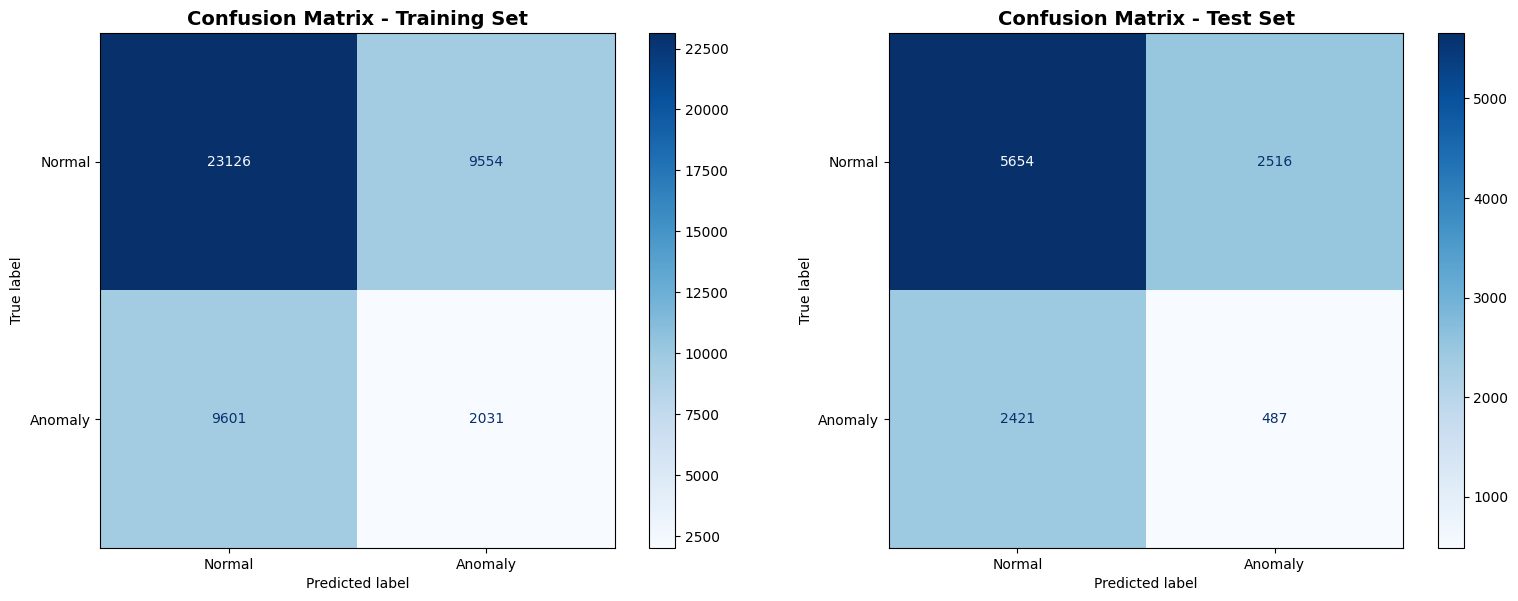

CONFUSION MATRIX - TRAINING SET:
True Negative (TN):  23,126 - Normal predicted as Normal
False Positive (FP): 9,554 - Normal predicted as Anomaly
False Negative (FN): 9,601 - Anomaly predicted as Normal
True Positive (TP):  2,031 - Anomaly predicted as Anomaly

CONFUSION MATRIX - TEST SET:
True Negative (TN):  5,654 - Normal predicted as Normal
False Positive (FP): 2,516 - Normal predicted as Anomaly
False Negative (FN): 2,421 - Anomaly predicted as Normal
True Positive (TP):  487 - Anomaly predicted as Anomaly


In [41]:
# ============================================================
# CONFUSION MATRIX
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix untuk training set
cm_train = confusion_matrix(y_train, y_train_pred_binary)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=['Normal', 'Anomaly'])
disp_train.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix - Training Set', fontsize=14, fontweight='bold')

# Confusion matrix untuk test set
cm_test = confusion_matrix(y_test, y_test_pred_binary)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=['Normal', 'Anomaly'])
disp_test.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print confusion matrix values
print("CONFUSION MATRIX - TRAINING SET:")
print(f"True Negative (TN):  {cm_train[0,0]:,} - Normal predicted as Normal")
print(f"False Positive (FP): {cm_train[0,1]:,} - Normal predicted as Anomaly")
print(f"False Negative (FN): {cm_train[1,0]:,} - Anomaly predicted as Normal")
print(f"True Positive (TP):  {cm_train[1,1]:,} - Anomaly predicted as Anomaly")
print()

print("CONFUSION MATRIX - TEST SET:")
print(f"True Negative (TN):  {cm_test[0,0]:,} - Normal predicted as Normal")
print(f"False Positive (FP): {cm_test[0,1]:,} - Normal predicted as Anomaly")
print(f"False Negative (FN): {cm_test[1,0]:,} - Anomaly predicted as Normal")
print(f"True Positive (TP):  {cm_test[1,1]:,} - Anomaly predicted as Anomaly")


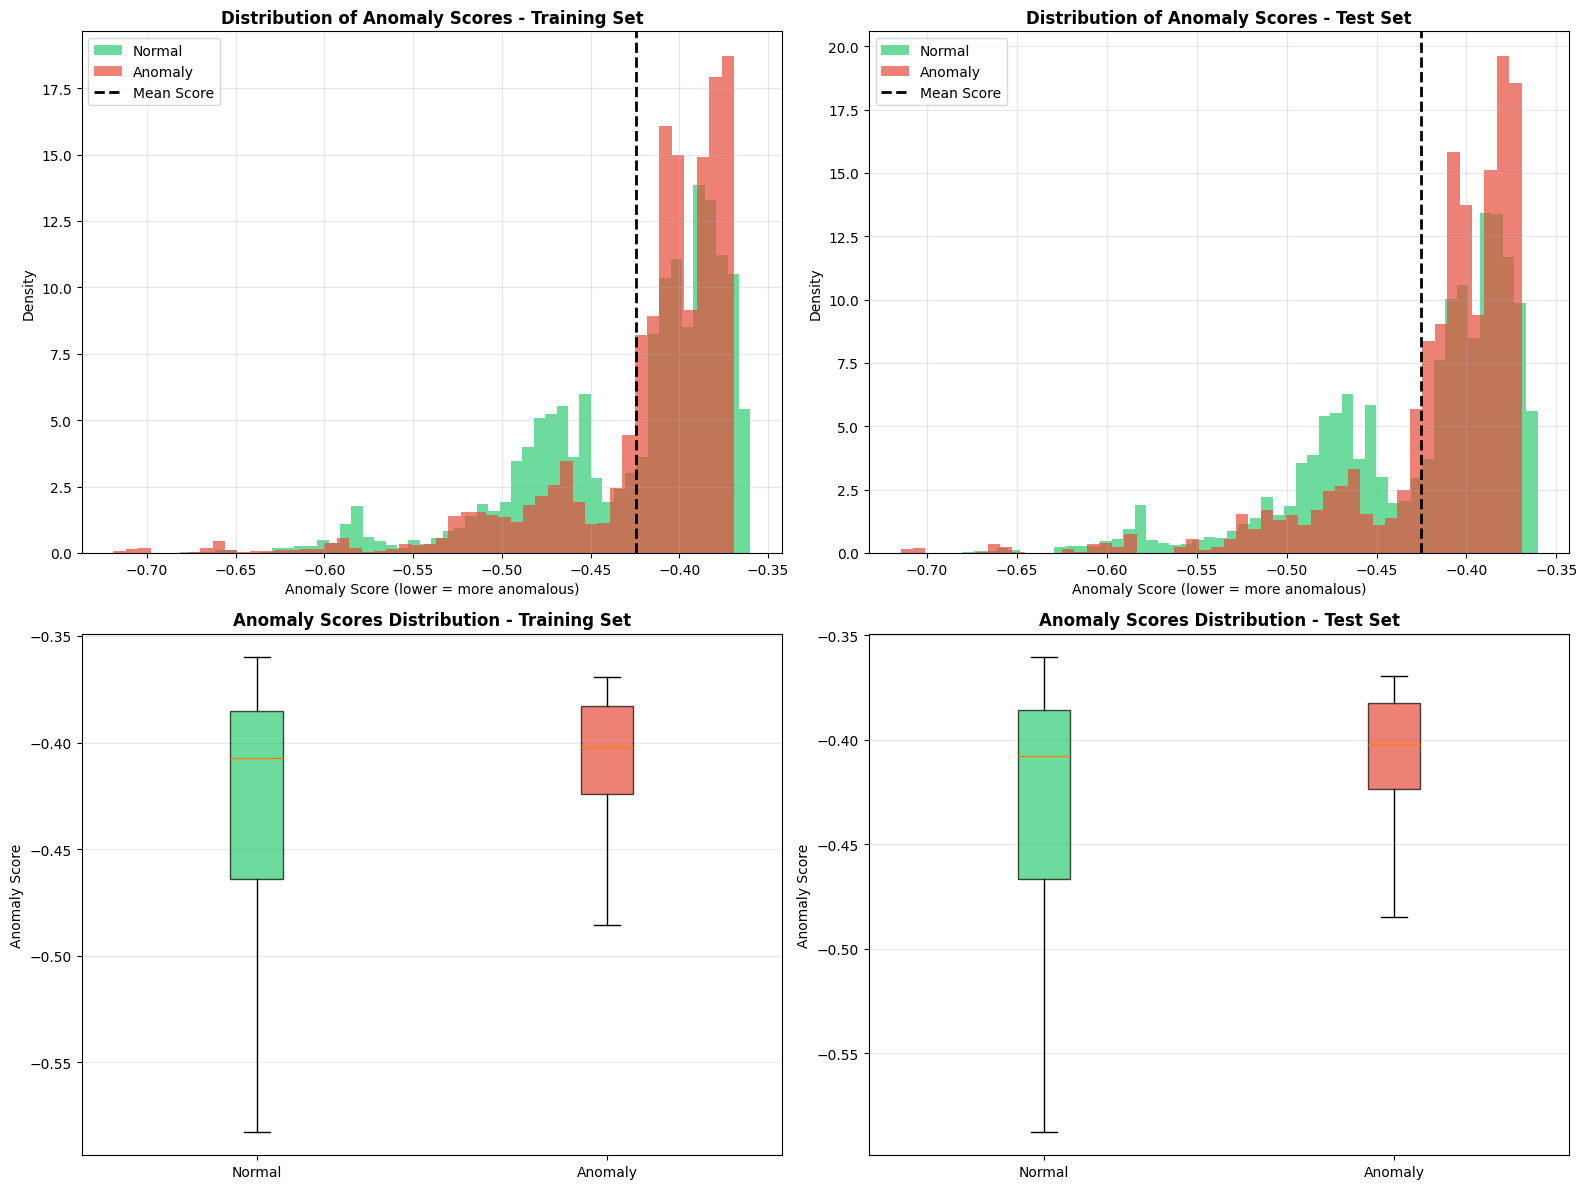

ANOMALY SCORE STATISTICS:
------------------------------------------------------------
Training Set:
  Normal  - Mean: -0.4271, Std: 0.0557
  Anomaly - Mean: -0.4163, Std: 0.0508

Test Set:
  Normal  - Mean: -0.4290, Std: 0.0569
  Anomaly - Mean: -0.4152, Std: 0.0495


In [42]:
# ============================================================
# VISUALISASI ANOMALY SCORES
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of anomaly scores - Training set
axes[0, 0].hist(train_scores[y_train == 0], bins=50, alpha=0.7, 
                label='Normal', color='#2ecc71', density=True)
axes[0, 0].hist(train_scores[y_train == 1], bins=50, alpha=0.7, 
                label='Anomaly', color='#e74c3c', density=True)
axes[0, 0].axvline(iso_forest.score_samples(X_train_scaled_df).mean(), 
                   color='black', linestyle='--', linewidth=2, label='Mean Score')
axes[0, 0].set_title('Distribution of Anomaly Scores - Training Set', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Anomaly Score (lower = more anomalous)', fontsize=10)
axes[0, 0].set_ylabel('Density', fontsize=10)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Distribution of anomaly scores - Test set
axes[0, 1].hist(test_scores[y_test == 0], bins=50, alpha=0.7, 
                label='Normal', color='#2ecc71', density=True)
axes[0, 1].hist(test_scores[y_test == 1], bins=50, alpha=0.7, 
                label='Anomaly', color='#e74c3c', density=True)
axes[0, 1].axvline(iso_forest.score_samples(X_test_scaled_df).mean(), 
                   color='black', linestyle='--', linewidth=2, label='Mean Score')
axes[0, 1].set_title('Distribution of Anomaly Scores - Test Set', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Anomaly Score (lower = more anomalous)', fontsize=10)
axes[0, 1].set_ylabel('Density', fontsize=10)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Box plot - Training set
train_normal_scores = train_scores[y_train == 0]
train_anomaly_scores = train_scores[y_train == 1]
bp1 = axes[1, 0].boxplot([train_normal_scores, train_anomaly_scores], 
                         labels=['Normal', 'Anomaly'], patch_artist=True, showfliers=False)
bp1['boxes'][0].set_facecolor('#2ecc71')
bp1['boxes'][0].set_alpha(0.7)
bp1['boxes'][1].set_facecolor('#e74c3c')
bp1['boxes'][1].set_alpha(0.7)
axes[1, 0].set_title('Anomaly Scores Distribution - Training Set', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Anomaly Score', fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Box plot - Test set
test_normal_scores = test_scores[y_test == 0]
test_anomaly_scores = test_scores[y_test == 1]
bp2 = axes[1, 1].boxplot([test_normal_scores, test_anomaly_scores], 
                         labels=['Normal', 'Anomaly'], patch_artist=True, showfliers=False)
bp2['boxes'][0].set_facecolor('#2ecc71')
bp2['boxes'][1].set_facecolor('#e74c3c')
bp2['boxes'][0].set_alpha(0.7)
bp2['boxes'][1].set_alpha(0.7)
axes[1, 1].set_title('Anomaly Scores Distribution - Test Set', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Anomaly Score', fontsize=10)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistik anomaly scores
print("ANOMALY SCORE STATISTICS:")
print("-" * 60)
print("Training Set:")
print(f"  Normal  - Mean: {train_normal_scores.mean():.4f}, Std: {train_normal_scores.std():.4f}")
print(f"  Anomaly - Mean: {train_anomaly_scores.mean():.4f}, Std: {train_anomaly_scores.std():.4f}")
print()
print("Test Set:")
print(f"  Normal  - Mean: {test_normal_scores.mean():.4f}, Std: {test_normal_scores.std():.4f}")
print(f"  Anomaly - Mean: {test_anomaly_scores.mean():.4f}, Std: {test_anomaly_scores.std():.4f}")


In [43]:
# ============================================================
# ANALISIS PREDIKSI vs ACTUAL LABEL
# ============================================================

# Buat DataFrame untuk analisis
results_train = pd.DataFrame({
    'actual': y_train.values,
    'predicted': y_train_pred_binary,
    'anomaly_score': train_scores
})

results_test = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_test_pred_binary,
    'anomaly_score': test_scores
})

# Analisis prediksi yang benar dan salah
print("=" * 70)
print("ANALISIS PREDIKSI - TRAINING SET")
print("=" * 70)

correct_train = results_train['actual'] == results_train['predicted']
print(f"Correct predictions: {correct_train.sum():,} ({correct_train.sum()/len(results_train)*100:.2f}%)")
print(f"Incorrect predictions: {(~correct_train).sum():,} ({(~correct_train).sum()/len(results_train)*100:.2f}%)")
print()

# Breakdown prediksi
print("Prediction breakdown:")
print(f"  True Positives (TP):  {((results_train['actual'] == 1) & (results_train['predicted'] == 1)).sum():,}")
print(f"  True Negatives (TN):  {((results_train['actual'] == 0) & (results_train['predicted'] == 0)).sum():,}")
print(f"  False Positives (FP): {((results_train['actual'] == 0) & (results_train['predicted'] == 1)).sum():,}")
print(f"  False Negatives (FN): {((results_train['actual'] == 1) & (results_train['predicted'] == 0)).sum():,}")
print()

# Anomaly score analysis
print("Anomaly Score Analysis:")
print(f"  Correct predictions - Mean score: {results_train[correct_train]['anomaly_score'].mean():.4f}")
print(f"  Incorrect predictions - Mean score: {results_train[~correct_train]['anomaly_score'].mean():.4f}")

print("\n" + "=" * 70)
print("ANALISIS PREDIKSI - TEST SET")
print("=" * 70)

correct_test = results_test['actual'] == results_test['predicted']
print(f"Correct predictions: {correct_test.sum():,} ({correct_test.sum()/len(results_test)*100:.2f}%)")
print(f"Incorrect predictions: {(~correct_test).sum():,} ({(~correct_test).sum()/len(results_test)*100:.2f}%)")
print()

# Breakdown prediksi
print("Prediction breakdown:")
print(f"  True Positives (TP):  {((results_test['actual'] == 1) & (results_test['predicted'] == 1)).sum():,}")
print(f"  True Negatives (TN):  {((results_test['actual'] == 0) & (results_test['predicted'] == 0)).sum():,}")
print(f"  False Positives (FP): {((results_test['actual'] == 0) & (results_test['predicted'] == 1)).sum():,}")
print(f"  False Negatives (FN): {((results_test['actual'] == 1) & (results_test['predicted'] == 0)).sum():,}")
print()

# Anomaly score analysis
print("Anomaly Score Analysis:")
print(f"  Correct predictions - Mean score: {results_test[correct_test]['anomaly_score'].mean():.4f}")
print(f"  Incorrect predictions - Mean score: {results_test[~correct_test]['anomaly_score'].mean():.4f}")


ANALISIS PREDIKSI - TRAINING SET
Correct predictions: 25,157 (56.77%)
Incorrect predictions: 19,155 (43.23%)

Prediction breakdown:
  True Positives (TP):  2,031
  True Negatives (TN):  23,126
  False Positives (FP): 9,554
  False Negatives (FN): 9,601

Anomaly Score Analysis:
  Correct predictions - Mean score: -0.4061
  Incorrect predictions - Mean score: -0.4482

ANALISIS PREDIKSI - TEST SET
Correct predictions: 6,141 (55.43%)
Incorrect predictions: 4,937 (44.57%)

Prediction breakdown:
  True Positives (TP):  487
  True Negatives (TN):  5,654
  False Positives (FP): 2,516
  False Negatives (FN): 2,421

Anomaly Score Analysis:
  Correct predictions - Mean score: -0.4059
  Incorrect predictions - Mean score: -0.4496


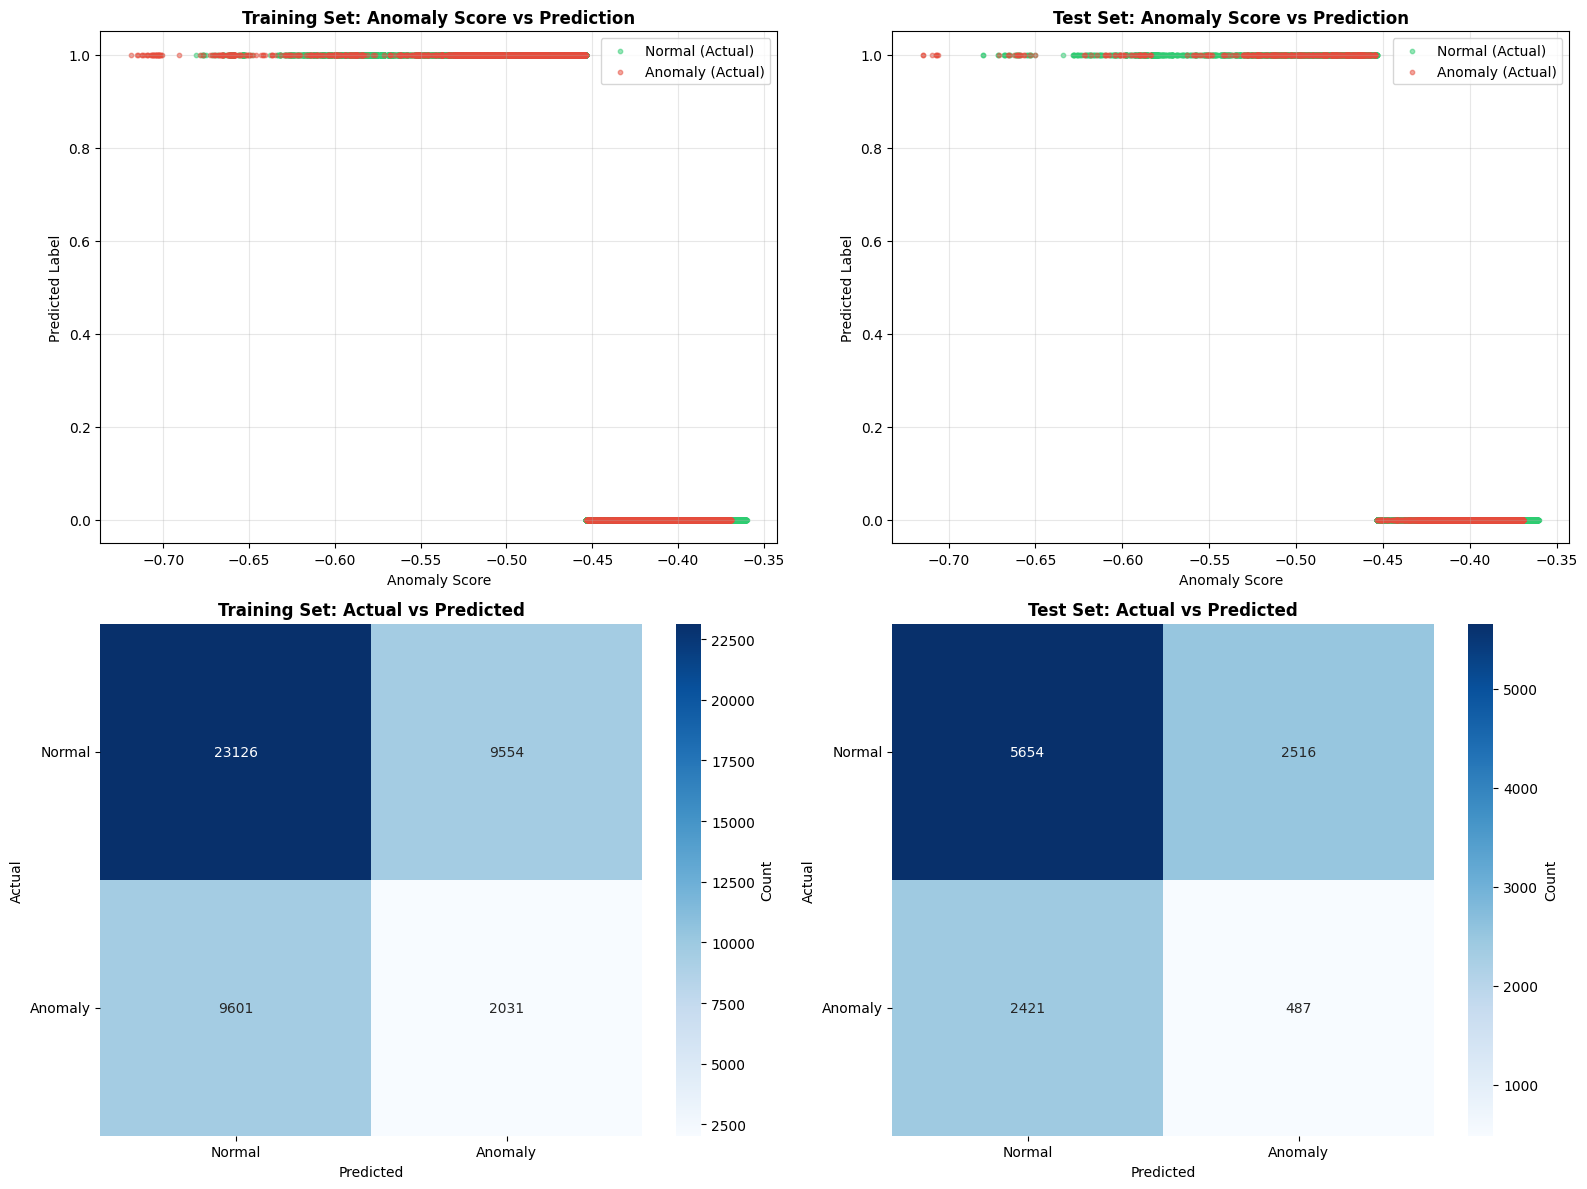

In [44]:
# ============================================================
# VISUALISASI PREDIKSI vs ACTUAL
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter plot: Anomaly Score vs Actual Label (Training)
scatter1 = axes[0, 0].scatter(results_train[results_train['actual'] == 0]['anomaly_score'], 
                              results_train[results_train['actual'] == 0]['predicted'],
                              alpha=0.5, s=10, c='#2ecc71', label='Normal (Actual)')
scatter2 = axes[0, 0].scatter(results_train[results_train['actual'] == 1]['anomaly_score'], 
                              results_train[results_train['actual'] == 1]['predicted'],
                              alpha=0.5, s=10, c='#e74c3c', label='Anomaly (Actual)')
axes[0, 0].set_xlabel('Anomaly Score', fontsize=10)
axes[0, 0].set_ylabel('Predicted Label', fontsize=10)
axes[0, 0].set_title('Training Set: Anomaly Score vs Prediction', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Scatter plot: Anomaly Score vs Actual Label (Test)
scatter3 = axes[0, 1].scatter(results_test[results_test['actual'] == 0]['anomaly_score'], 
                              results_test[results_test['actual'] == 0]['predicted'],
                              alpha=0.5, s=10, c='#2ecc71', label='Normal (Actual)')
scatter4 = axes[0, 1].scatter(results_test[results_test['actual'] == 1]['anomaly_score'], 
                              results_test[results_test['actual'] == 1]['predicted'],
                              alpha=0.5, s=10, c='#e74c3c', label='Anomaly (Actual)')
axes[0, 1].set_xlabel('Anomaly Score', fontsize=10)
axes[0, 1].set_ylabel('Predicted Label', fontsize=10)
axes[0, 1].set_title('Test Set: Anomaly Score vs Prediction', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Comparison: Actual vs Predicted (Training)
comparison_train = pd.crosstab(results_train['actual'], results_train['predicted'], 
                               rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(comparison_train, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0], 
            cbar_kws={'label': 'Count'})
axes[1, 0].set_title('Training Set: Actual vs Predicted', fontsize=12, fontweight='bold')
axes[1, 0].set_yticklabels(['Normal', 'Anomaly'], rotation=0)
axes[1, 0].set_xticklabels(['Normal', 'Anomaly'])

# 4. Comparison: Actual vs Predicted (Test)
comparison_test = pd.crosstab(results_test['actual'], results_test['predicted'], 
                              rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(comparison_test, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], 
            cbar_kws={'label': 'Count'})
axes[1, 1].set_title('Test Set: Actual vs Predicted', fontsize=12, fontweight='bold')
axes[1, 1].set_yticklabels(['Normal', 'Anomaly'], rotation=0)
axes[1, 1].set_xticklabels(['Normal', 'Anomaly'])

plt.tight_layout()
plt.show()


In [46]:
# ============================================================
# RINGKASAN HASIL PEMODELAN
# ============================================================

print("=" * 70)
print("RINGKASAN HASIL PEMODELAN ISOLATION FOREST")
print("=" * 70)


print("\n2. DATA SPLIT:")
print(f"   - Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.2f}%)")
print(f"   - Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.2f}%)")

print("\n3. MODEL PERFORMANCE - TEST SET:")
print(f"   - Accuracy : {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   - Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"   - Recall   : {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"   - F1-Score : {test_f1:.4f} ({test_f1*100:.2f}%)")

print("\n4. CONFUSION MATRIX - TEST SET:")
print(f"   - True Positives (TP):  {cm_test[1,1]:,} - Anomaly correctly detected")
print(f"   - True Negatives (TN):  {cm_test[0,0]:,} - Normal correctly identified")
print(f"   - False Positives (FP): {cm_test[0,1]:,} - Normal misclassified as Anomaly")
print(f"   - False Negatives (FN): {cm_test[1,0]:,} - Anomaly missed (misclassified as Normal)")

print("\n5. INTERPRETATION:")
if test_recall > 0.8:
    print("   ✓ Model memiliki recall tinggi - dapat mendeteksi sebagian besar anomaly")
else:
    print("   ⚠ Model memiliki recall rendah - banyak anomaly yang terlewat")

if test_precision > 0.8:
    print("   ✓ Model memiliki precision tinggi - prediksi anomaly sebagian besar benar")
else:
    print("   ⚠ Model memiliki precision rendah - banyak false positives")

if test_f1 > 0.7:
    print("   ✓ Model memiliki F1-score baik - balance antara precision dan recall")
else:
    print("   ⚠ Model perlu improvement - F1-score masih rendah")

print("\n" + "=" * 70)


RINGKASAN HASIL PEMODELAN ISOLATION FOREST

2. DATA SPLIT:
   - Training set: 44,312 samples (80.00%)
   - Test set: 11,078 samples (20.00%)

3. MODEL PERFORMANCE - TEST SET:
   - Accuracy : 0.5543 (55.43%)
   - Precision: 0.1622 (16.22%)
   - Recall   : 0.1675 (16.75%)
   - F1-Score : 0.1648 (16.48%)

4. CONFUSION MATRIX - TEST SET:
   - True Positives (TP):  487 - Anomaly correctly detected
   - True Negatives (TN):  5,654 - Normal correctly identified
   - False Positives (FP): 2,516 - Normal misclassified as Anomaly
   - False Negatives (FN): 2,421 - Anomaly missed (misclassified as Normal)

5. INTERPRETATION:
   ⚠ Model memiliki recall rendah - banyak anomaly yang terlewat
   ⚠ Model memiliki precision rendah - banyak false positives
   ⚠ Model perlu improvement - F1-score masih rendah

